In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
#Linux
sys.path.append('/home/noise/Documentos/credit_risk')
# Adicionando o caminho do sistema para o Grauna
# Windows
#sys.path.append('C:\\Users\\Graúna Motos\\Documents\\credit_risk')

from src.utils_modelling import analisy_univariate, wo_discretize, plot_woe, wo_discretize_continuos


In [112]:
# Linux
df = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_2007_2014.csv')

/tmp/ipykernel_49903/4179930082.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/noise/Documentos/credit_risk/data/loan_data_2007_2014.csv')


In [113]:
#df = pd.read_csv('C:\\Users\\Graúna Motos\\Documents\\credit_risk\\data\\bronze\\loan_data_2007_2014 (1).csv')

In [114]:
def clean(value):
    if pd.isna(value):
        return 0
    elif '10+' in value:
        return 10
    elif '<' in value:
        return 0
    else:
        return float(value.split()[0])
    
df['emp_length_int'] = df['emp_length'].apply(clean)

In [115]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [116]:
pd.to_datetime('2017-12-01') - df['earliest_cr_line_date'] 

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [117]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['earliest_cr_line_date']) / np.timedelta64(1, 'm')))

In [118]:
df.loc[:, ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-23536800.0
1770,Sep-68,2068-09-01,-26693280.0
2799,Sep-64,2064-09-01,-24589440.0
3282,Sep-67,2067-09-01,-26166240.0
3359,Feb-65,2065-02-01,-24809760.0
...,...,...,...
464003,Jan-68,2068-01-01,-26341920.0
464260,Jul-66,2066-07-01,-25551360.0
465100,Oct-67,2067-10-01,-26209440.0
465500,Sep-67,2067-09-01,-26166240.0


In [119]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

/tmp/ipykernel_49903/3793766548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()


In [120]:
min(df['mths_since_earliest_cr_line'])

3199680.0

In [121]:
def clean_term(value):
    if pd.isna(value):
        return 0
    elif ' 36 months' in value:
        return 36
    elif ' 60 months' in value:
        return 60
    else:
        return float(value.split()[0])

In [122]:
df['term_int'] = df['term'].apply(clean_term)

In [123]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')

In [124]:
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['issue_d_date'])/np.timedelta64(1, 'm')))

In [125]:
threshold = 10
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < threshold]
print("Variáveis categóricas confirmadas:", categorical_columns)


Variáveis categóricas confirmadas: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'application_type']


In [126]:
df_dummies = [
    pd.get_dummies(df['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(df['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(df['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(df['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(df['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(df['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(df['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(df['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),

]

In [127]:
df_dummies = pd.concat(df_dummies, axis=1)

In [128]:
df = pd.concat([df, df_dummies], axis=1)

/home/noise/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


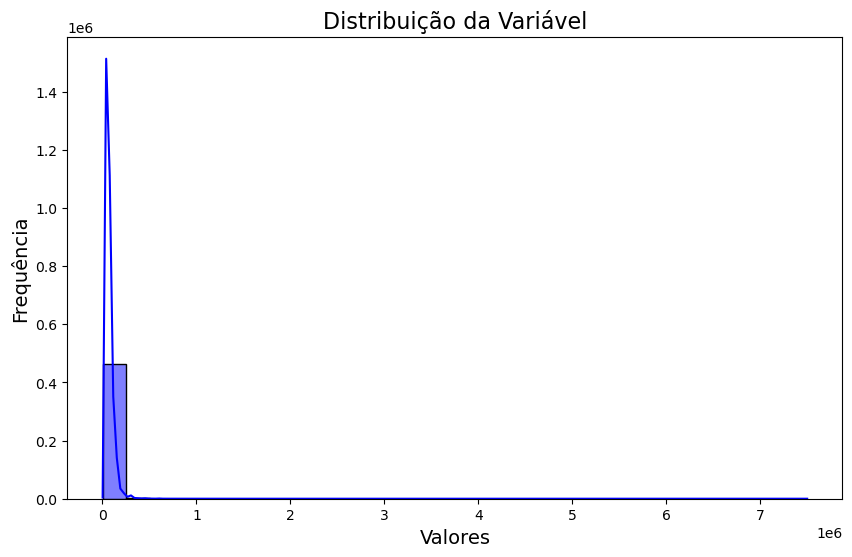

In [129]:
plt.figure(figsize=(10, 6))

# Histograma com KDE (Kernel Density Estimate)
sns.histplot(df['annual_inc'], bins=30, kde=True, color='blue')

# Adicionando título e rótulos
plt.title('Distribuição da Variável', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Exibir o gráfico
plt.show()

In [130]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)


In [131]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)

In [132]:
df['good_bad']
pd.options.display.max_columns = None


In [133]:
df_input_train, df_input_test, df_target_train, df_target_test = train_test_split(df.drop('good_bad', axis = 1), df['good_bad'], test_size=0.2, random_state=42)


In [134]:
df_inputs_prepr = df_input_test
df_target_prepr = df_target_test

In [135]:
df1 = pd.concat([df_inputs_prepr['grade'], df_target_prepr], axis = 1)


In [136]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].count()


,grade,good_bad
0,A,15108
1,B,27199
2,C,25048
3,D,15390
4,E,7145
5,F,2699
6,G,668


In [137]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].mean()


,grade,good_bad
0,A,0.962338
1,B,0.923085
2,C,0.882905
3,D,0.844314
4,E,0.805178
5,F,0.775472
6,G,0.697605


## Preprocessing Variable Discrete

In [138]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count(),
                 df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()], axis = 1)

In [139]:
df_grade = wo_discretize(df_inputs_prepr, 'grade', df_target_prepr)

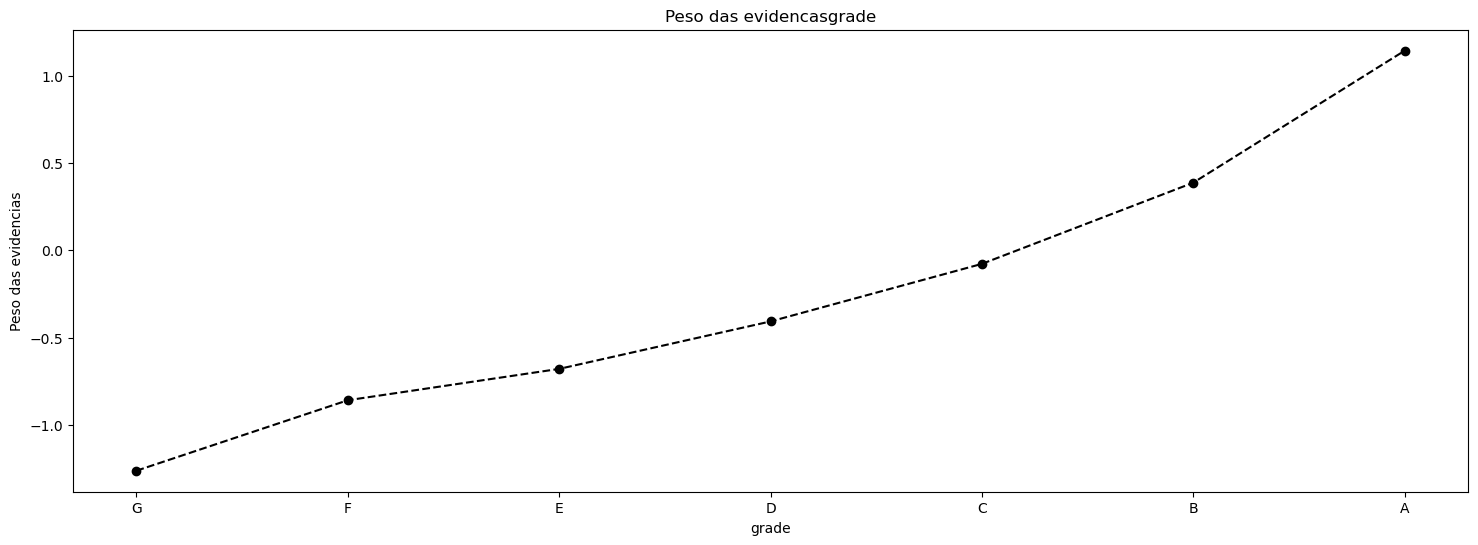

In [140]:
plot_woe(df_grade)

In [141]:
df_home = wo_discretize(df_inputs_prepr, 'home_ownership', df_target_prepr)

In [142]:
df_home

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,OTHER,45,0.777778,0.000483,35.0,10.0,0.000421,0.000981,-0.845478,NaN,NaN,0.000473,0.022938
1,NONE,10,0.800000,0.000107,8.0,2.0,0.000096,0.000196,-0.711946,0.022222,0.133531,0.000071,0.022938
2,RENT,37874,0.874003,0.406125,33102.0,4772.0,0.398498,0.468302,-0.161412,0.074003,0.550534,0.011267,0.022938
3,OWN,8409,0.888572,0.090170,7472.0,937.0,0.089951,0.091953,-0.022006,0.014568,0.139406,0.000044,0.022938
4,MORTGAGE,46919,0.904751,0.503115,42450.0,4469.0,0.511033,0.438567,0.152922,0.016179,0.174928,0.011082,0.022938


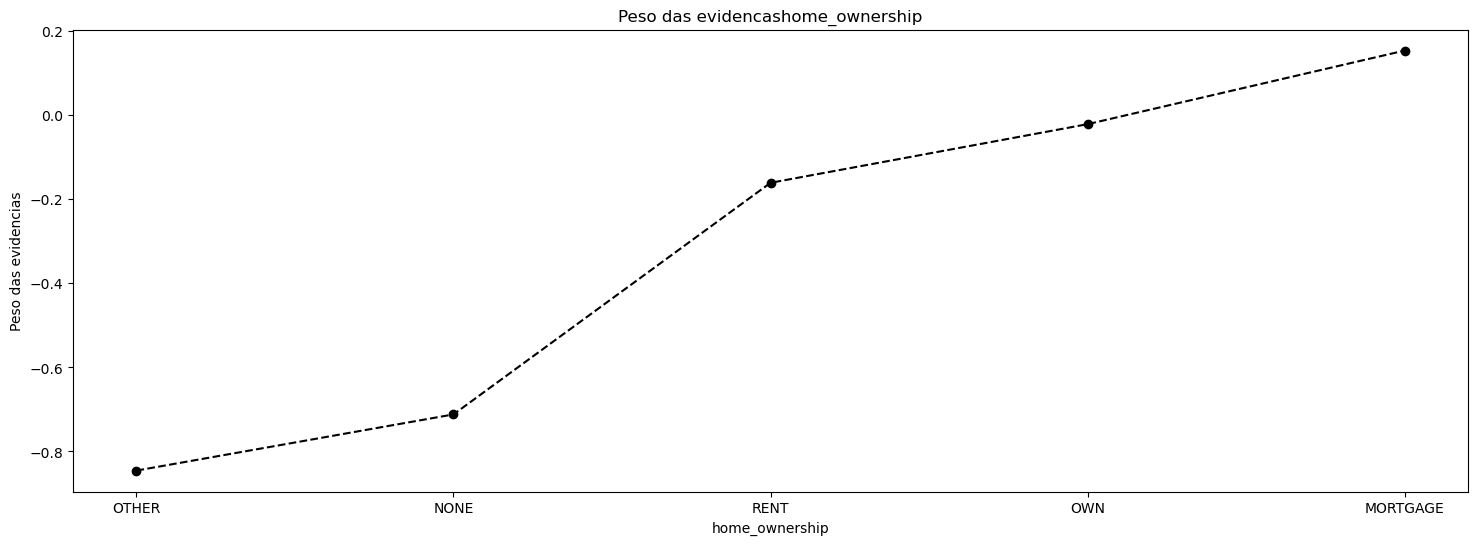

In [143]:
plot_woe(df_home)

In [144]:
df_grade = wo_discretize(df_inputs_prepr, 'purpose', df_target_prepr)

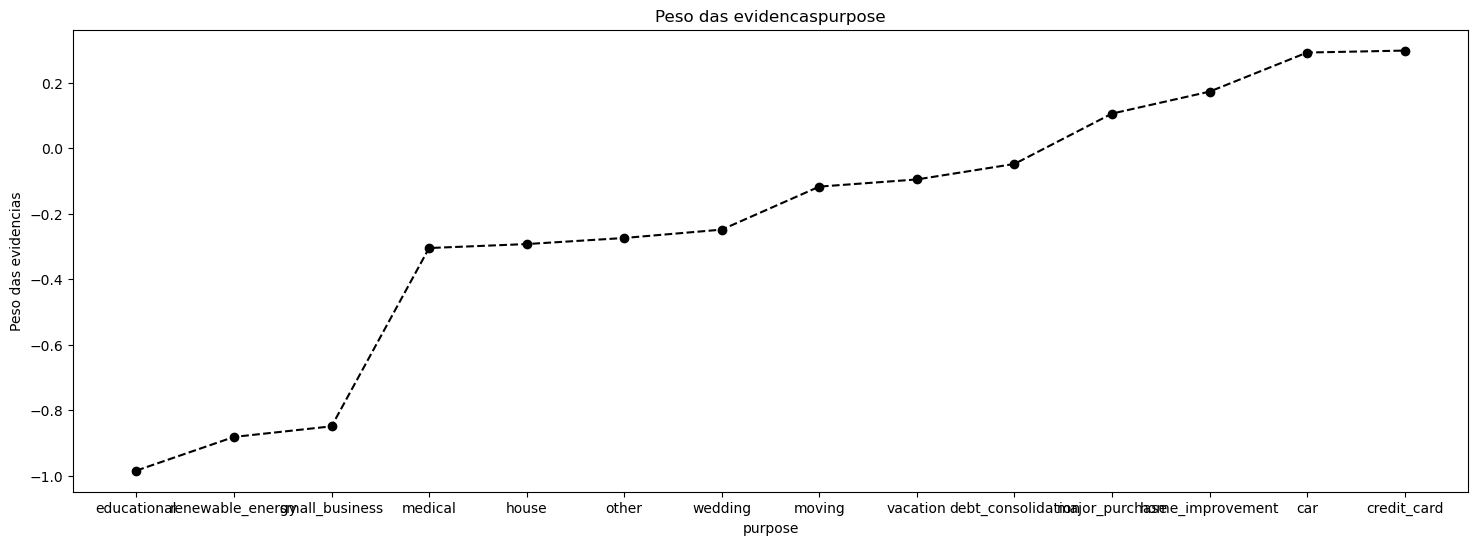

In [145]:
plot_woe(df_grade)

In [146]:
df_status = wo_discretize(df_inputs_prepr, 'verification_status', df_target_prepr)

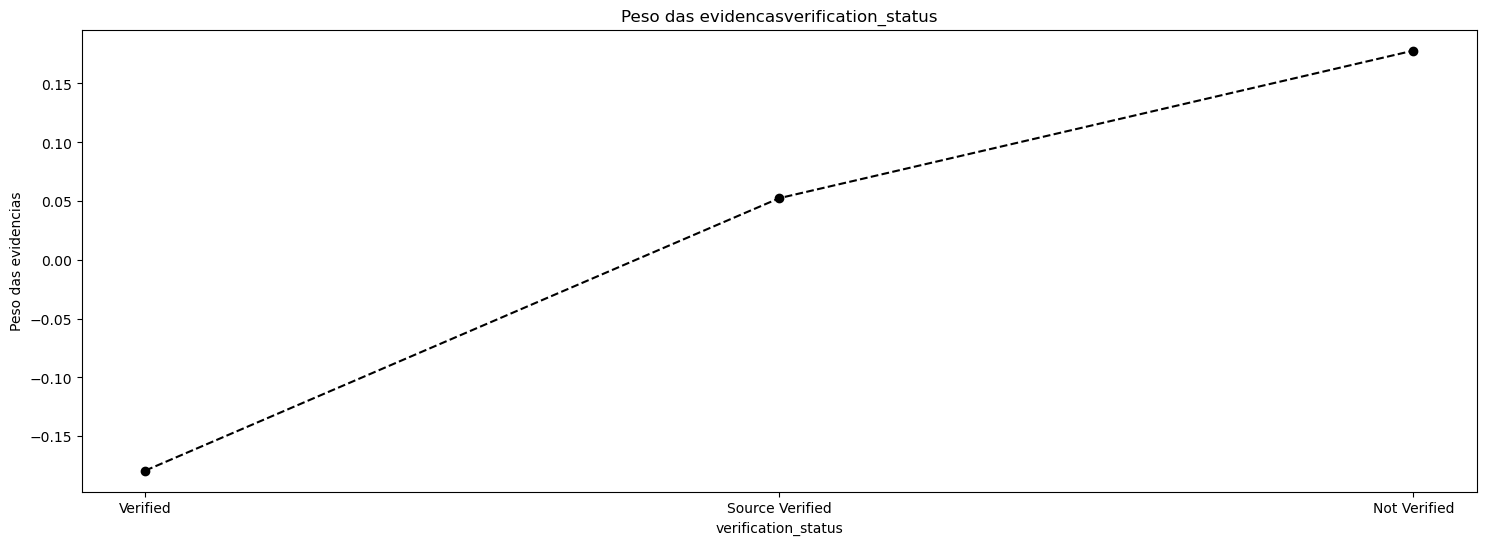

In [147]:
plot_woe(df_status)

In [148]:
df_initial = wo_discretize(df_inputs_prepr, 'initial_list_status', df_target_prepr)

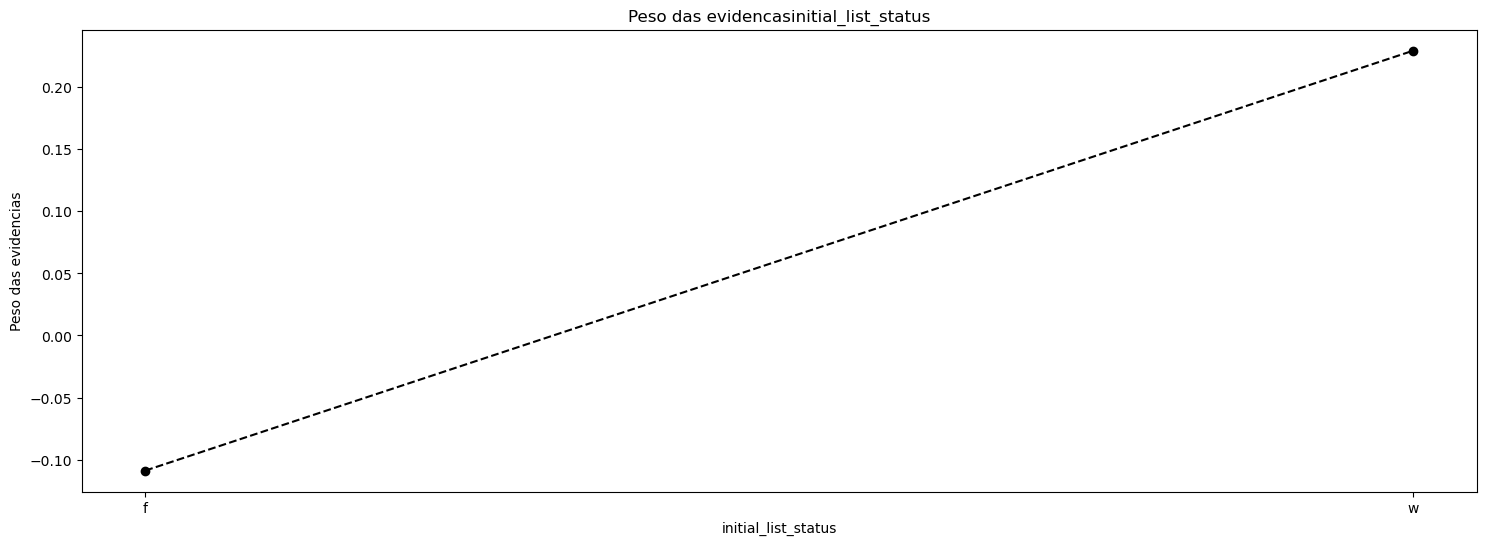

In [149]:
plot_woe(df_initial)

In [150]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [151]:
df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'], df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'], df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'],df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'],df_inputs_prepr['addr_state:TN'], df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'], df_inputs_prepr['addr_state:MD'],
df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'], df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'],df_inputs_prepr['addr_state:MI'], df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'],df_inputs_prepr['addr_state:MA'], df_inputs_prepr['addr_state:DE'],
df_inputs_prepr['addr_state:SD'], df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'], df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'],df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'], df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'], df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])




In [152]:
df_inputs_prepr['purpose:educ_smb_wedd_ren_en_mov_house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'], df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])

df_inputs_prepr['purpose:oth_med_vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'], df_inputs_prepr['purpose:vacation']])

df_inputs_prepr['purpose:major_car_home'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'], df_inputs_prepr['purpose:home_improvement']])

In [153]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],  df_inputs_prepr['home_ownership:NONE'],  df_inputs_prepr['home_ownership:ANY']])

In [154]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE'],df_inputs_prepr['home_ownership:ANY']])

## Preprocessing Variables Continuous

In [155]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'term_int', df_target_prepr)

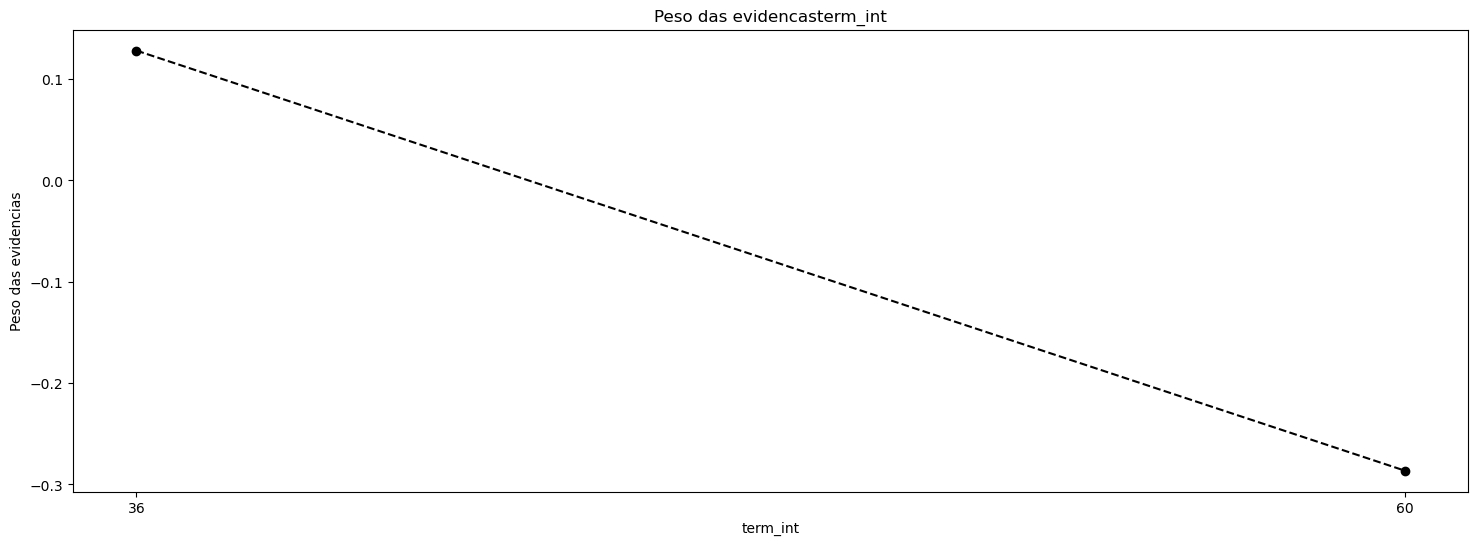

In [156]:
plot_woe(df_temp)

In [157]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int']== 36),1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int']== 60),1, 0)

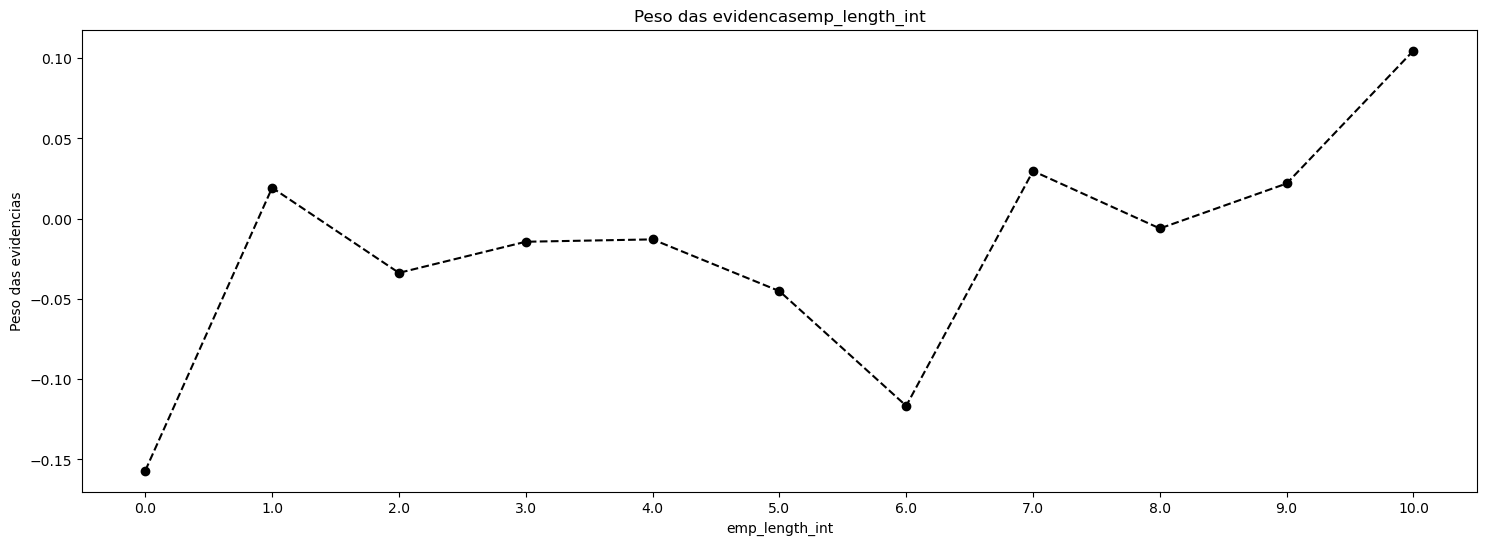

In [158]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'emp_length_int', df_target_prepr)
plot_woe(df_temp)

In [159]:
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]),1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]),1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin([2,5]),1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin([5,7]),1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin([7,10]),1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]),1, 0)


In [160]:
df_inputs_prepr['mths_since_issue_d_factor'] = pd.cut(df_inputs_prepr['mths_since_issue_d'], 50)

In [161]:
df_inputs_prepr['mths_since_issue_d_factor']

362514    (1736064.0, 1814976.0]
288564    (1657152.0, 1736064.0]
213591    (2840832.0, 2919744.0]
263083    (1574294.4, 1657152.0]
165001    (2525184.0, 2604096.0]
                   ...          
115       (3077568.0, 3156480.0]
296284    (1657152.0, 1736064.0]
61777     (2130624.0, 2209536.0]
91763     (2209536.0, 2288448.0]
167512    (2525184.0, 2604096.0]
Name: mths_since_issue_d_factor, Length: 93257, dtype: category
Categories (50, interval[float64, right]): [(1574294.4, 1657152.0] < (1657152.0, 1736064.0] < (1736064.0, 1814976.0] < (1814976.0, 1893888.0] ... (5208192.0, 5287104.0] < (5287104.0, 5366016.0] < (5366016.0, 5444928.0] < (5444928.0, 5523840.0]]

In [162]:
df_inputs_prepr['mths_since_issue_d:<38'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38)),1,0)
df_inputs_prepr['mths_since_issue_d:38-39'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(38, 40)),1,0)
df_inputs_prepr['mths_since_issue_d:40-41'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(40, 42)),1,0)
df_inputs_prepr['mths_since_issue_d:42-48'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(42,49)),1,0)
df_inputs_prepr['mths_since_issue_d:49-52'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(49,53)),1,0)
df_inputs_prepr['mths_since_issue_d:53-64'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(53,65)),1,0)
df_inputs_prepr['mths_since_issue_d:65-84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(65,85)),1,0)
df_inputs_prepr['mths_since_issue_d:>84'] = np.where(df_inputs_prepr['mths_since_issue_d'].isin(range(85, int(df_inputs_prepr['mths_since_issue_d'].max()))), 1, 0)


/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


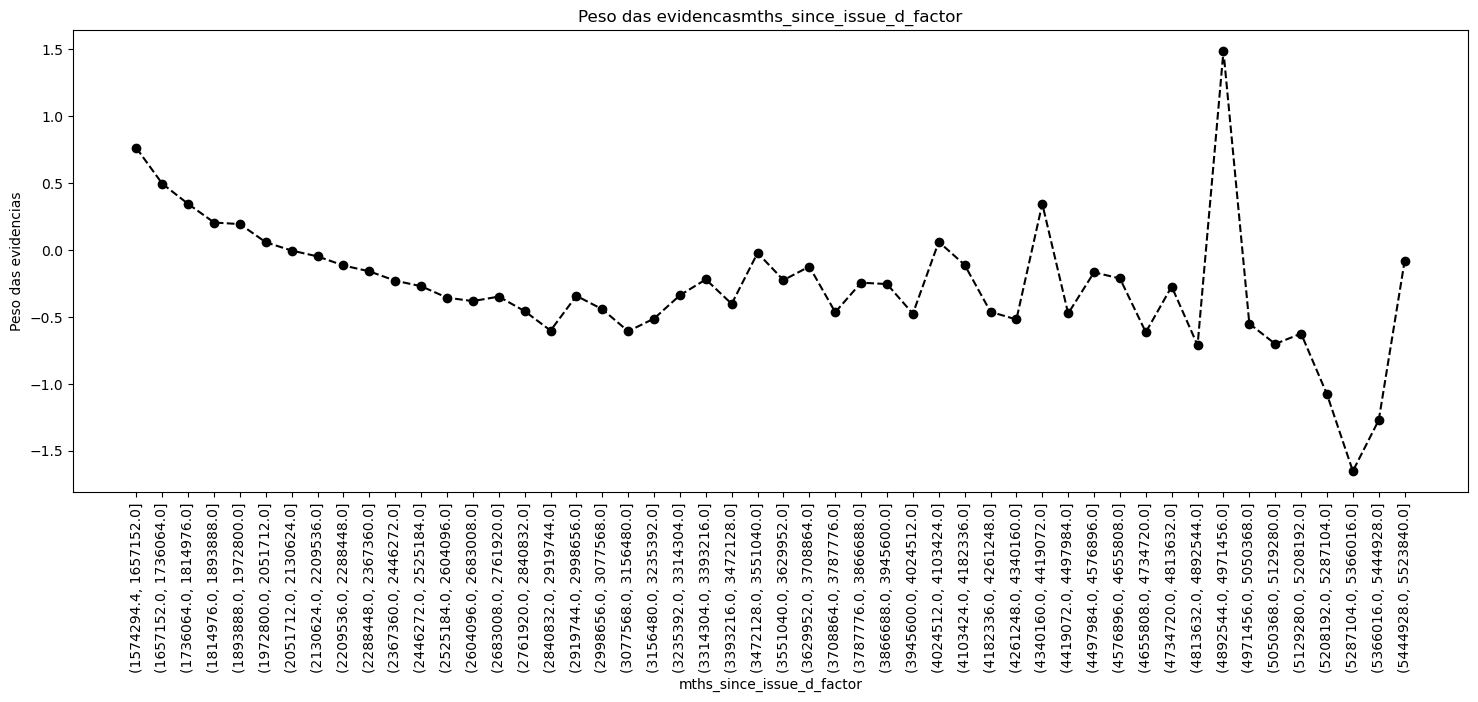

In [163]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'mths_since_issue_d_factor', df_target_prepr)
plot_woe(df_temp, rotation_axis= 90)

In [164]:
df_inputs_prepr['int_rate_factor'] = pd.cut(df_inputs_prepr['int_rate'], 50)

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


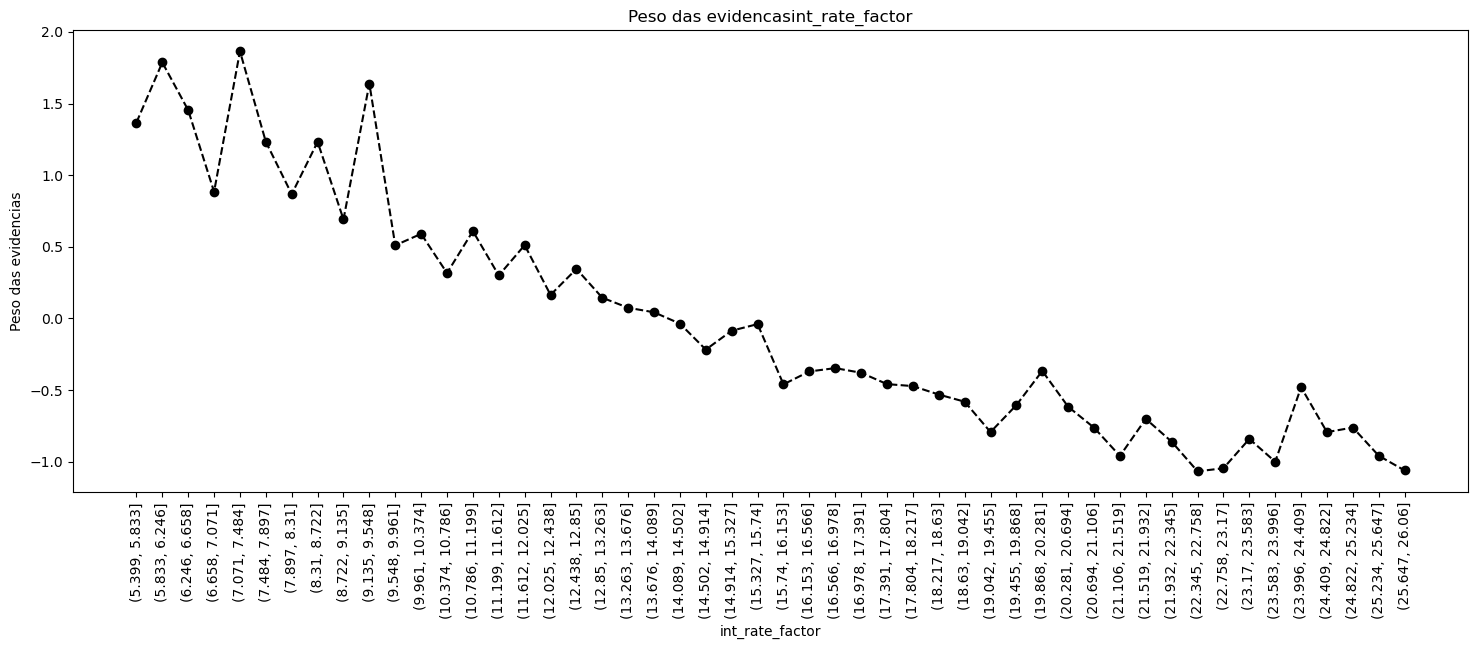

In [165]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'int_rate_factor', df_target_prepr)
plot_woe(df_temp, rotation_axis= 90)

In [166]:
df_inputs_prepr['int_rate:<9.548'] = np.where((df_inputs_prepr['int_rate'] <= 9.548), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:12.025-15.74'] = np.where((df_inputs_prepr['int_rate'] > 12.025) & (df_inputs_prepr['int_rate'] <= 15.74), 1, 0)
df_inputs_prepr['int_rate:15.74-20.281'] = np.where((df_inputs_prepr['int_rate'] > 15.74) & (df_inputs_prepr['int_rate'] <= 20.281), 1, 0)
df_inputs_prepr['int_rate:9.548-12.025'] = np.where((df_inputs_prepr['int_rate'] > 9.548) & (df_inputs_prepr['int_rate'] <= 12.025), 1, 0)
df_inputs_prepr['int_rate:>20.281'] = np.where((df_inputs_prepr['int_rate'] > 20.281), 1, 0)



In [167]:
# funded_amnt
df_inputs_prepr['funded_amnt_factor'] = pd.cut(df_inputs_prepr['funded_amnt'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'funded_amnt_factor', df_target_prepr)
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,funded_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(465.5, 1190.0]",319,0.880878,0.003421,281.0,38.0,0.003383,0.003729,-0.097472,NaN,NaN,3.375799e-05,0.018663
1,"(1190.0, 1880.0]",800,0.896250,0.008578,717.0,83.0,0.008632,0.008145,0.057995,0.015372,0.155467,2.820543e-05,0.018663
2,"(1880.0, 2570.0]",1513,0.900198,0.016224,1362.0,151.0,0.016396,0.014818,0.101189,0.003948,0.043194,1.596715e-04,0.018663
3,"(2570.0, 3260.0]",1817,0.893781,0.019484,1624.0,193.0,0.019550,0.018940,0.031717,0.006417,0.069472,1.935814e-05,0.018663
4,"(3260.0, 3950.0]",1245,0.891566,0.013350,1110.0,135.0,0.013363,0.013248,0.008600,0.002215,0.023117,9.840345e-07,0.018663
5,"(3950.0, 4640.0]",2298,0.882942,0.024642,2029.0,269.0,0.024426,0.026398,-0.077654,0.008625,0.086254,1.531614e-04,0.018663
6,"(4640.0, 5330.0]",3957,0.898155,0.042431,3554.0,403.0,0.042785,0.039549,0.078652,0.015213,0.156305,2.545300e-04,0.018663
7,"(5330.0, 6020.0]",4186,0.906593,0.044887,3795.0,391.0,0.045686,0.038371,0.174491,0.008438,0.095840,1.276416e-03,0.018663
8,"(6020.0, 6710.0]",1718,0.881839,0.018422,1515.0,203.0,0.018238,0.019921,-0.088276,0.024754,0.262767,1.485862e-04,0.018663
9,"(6710.0, 7400.0]",2880,0.893403,0.030882,2573.0,307.0,0.030975,0.030128,0.027739,0.011563,0.116015,2.350692e-05,0.018663


In [168]:
df_inputs_prepr['mths_since_earliest_cr_line_factor'] = pd.cut(df_inputs_prepr['mths_since_earliest_cr_line'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'mths_since_earliest_cr_line_factor', df_target_prepr)
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,mths_since_earliest_cr_line_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-25727.04, 514540.8]",5,1.000000,0.000054,5.0,0.0,0.000060,0.000000,inf,NaN,NaN,inf,inf
1,"(514540.8, 1029081.6]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,"(1029081.6, 1543622.4]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,"(1543622.4, 2058163.2]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,"(2058163.2, 2572704.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
5,"(2572704.0, 3087244.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
6,"(3087244.8, 3601785.6]",182,0.923077,0.001952,168.0,14.0,0.002022,0.001374,0.386666,NaN,NaN,0.000251,inf
7,"(3601785.6, 4116326.4]",508,0.913386,0.005447,464.0,44.0,0.005586,0.004318,0.257454,0.009691,0.129212,0.000326,inf
8,"(4116326.4, 4630867.2]",715,0.851748,0.007667,609.0,106.0,0.007331,0.010402,-0.349861,0.061638,0.607316,0.001074,inf
9,"(4630867.2, 5145408.0]",1268,0.854890,0.013597,1084.0,184.0,0.013050,0.018057,-0.324763,0.003141,0.025098,0.001626,inf


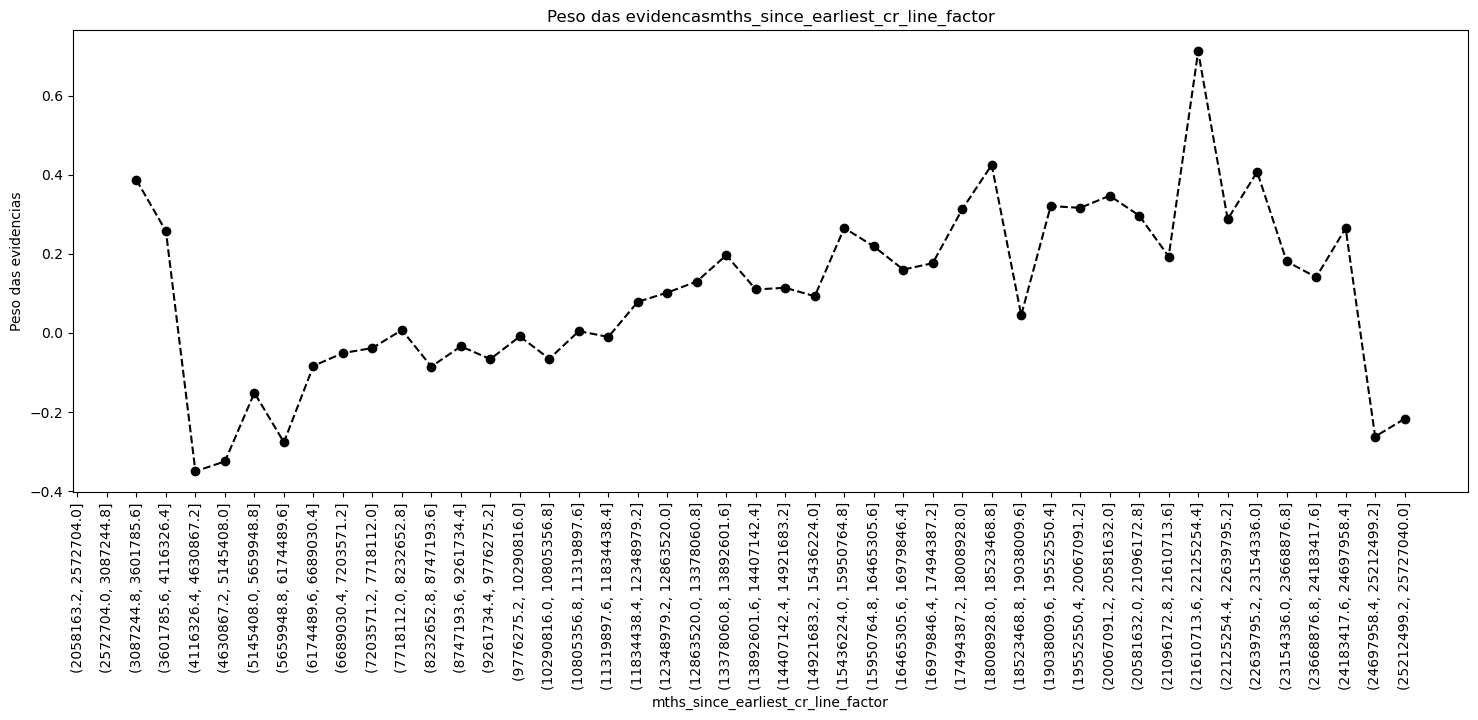

In [169]:
plot_woe(df_temp, 90)


In [170]:
# We create the following categories:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
df_inputs_prepr['mths_since_earliest_cr_line:<140'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:141-164'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:165-247'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:248-270'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:271-352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
df_inputs_prepr['mths_since_earliest_cr_line:>352'] = np.where(df_inputs_prepr['mths_since_earliest_cr_line'].isin(range(353, int(df_inputs_prepr['mths_since_earliest_cr_line'].max()))), 1, 0)

In [171]:
# delinq_2yrs
df_temp = wo_discretize_continuos(df_inputs_prepr, 'delinq_2yrs', df_target_prepr)
# We calculate weight of evidence.
df_temp

,delinq_2yrs,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,76566,0.890944,0.821021,68216.0,8350.0,0.821217,0.819431,0.002177,NaN,NaN,3.887564e-06,inf
1,1.0,11297,0.890413,0.121138,10059.0,1238.0,0.121095,0.121492,-0.003270,0.000530,0.005447,1.297041e-06,inf
2,2.0,3192,0.885025,0.034228,2825.0,367.0,0.034009,0.036016,-0.057339,0.005388,0.054069,1.150797e-04,inf
3,3.0,1134,0.893298,0.012160,1013.0,121.0,0.012195,0.011874,0.026640,0.008273,0.083979,8.540572e-06,inf
4,4.0,510,0.886275,0.005469,452.0,58.0,0.005441,0.005692,-0.045001,0.007024,0.071642,1.127126e-05,inf
5,5.0,270,0.911111,0.002895,246.0,24.0,0.002961,0.002355,0.229037,0.024837,0.274039,1.388456e-04,inf
6,6.0,128,0.859375,0.001373,110.0,18.0,0.001324,0.001766,-0.288132,0.051736,0.517169,1.274136e-04,inf
7,7.0,67,0.925373,0.000718,62.0,5.0,0.000746,0.000491,0.419456,0.065998,0.707588,1.072583e-04,inf
8,8.0,29,0.896552,0.000311,26.0,3.0,0.000313,0.000294,0.061244,0.028821,0.358212,1.138767e-06,inf
9,9.0,22,0.954545,0.000236,21.0,1.0,0.000253,0.000098,0.946282,0.057994,0.885038,1.463638e-04,inf


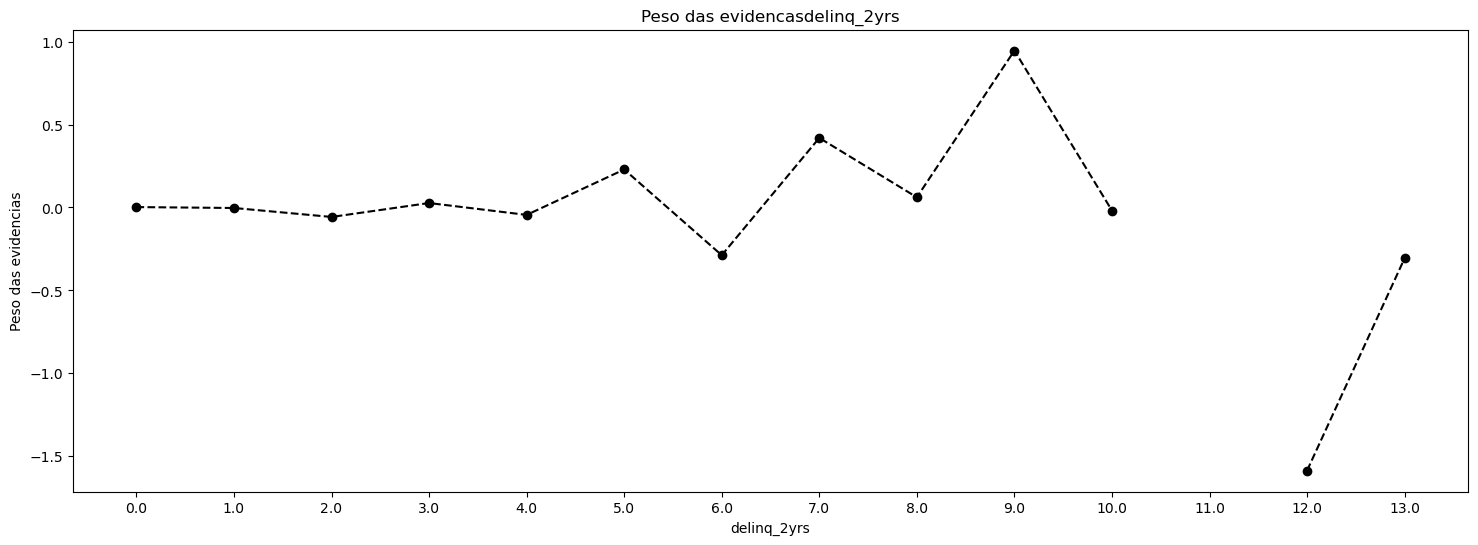

In [172]:
plot_woe(df_temp)
# We plot the weight of evidence values.

In [173]:
# Categories: 0, 1-3, >=4
df_inputs_prepr['delinq_2yrs:0'] = np.where((df_inputs_prepr['delinq_2yrs'] == 0), 1, 0)
df_inputs_prepr['delinq_2yrs:1-3'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 1) & (df_inputs_prepr['delinq_2yrs'] <= 3), 1, 0)
df_inputs_prepr['delinq_2yrs:>=4'] = np.where((df_inputs_prepr['delinq_2yrs'] >= 9), 1, 0)

In [174]:
# inq_last_6mths
df_temp = wo_discretize_continuos(df_inputs_prepr, 'inq_last_6mths', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,48295,0.910094,0.517870,43953.0,4342.0,0.529127,0.426104,0.216545,NaN,NaN,0.022309,inf
1,1.0,25985,0.882394,0.278639,22929.0,3056.0,0.276030,0.299902,-0.082945,0.027701,0.299490,0.001980,inf
2,2.0,11611,0.861252,0.124505,10000.0,1611.0,0.120385,0.158096,-0.272511,0.021141,0.189566,0.010277,inf
3,3.0,5086,0.846245,0.054537,4304.0,782.0,0.051814,0.076742,-0.392795,0.015008,0.120285,0.009792,inf
4,4.0,1431,0.841370,0.015345,1204.0,227.0,0.014494,0.022277,-0.429786,0.004875,0.036991,0.003345,inf
5,5.0,551,0.842105,0.005908,464.0,87.0,0.005586,0.008538,-0.424264,0.000736,0.005522,0.001252,inf
6,6.0,211,0.763033,0.002263,161.0,50.0,0.001938,0.004907,-0.928859,0.079072,0.504595,0.002757,inf
7,7.0,36,0.527778,0.000386,19.0,17.0,0.000229,0.001668,-1.987015,0.235255,1.058156,0.002860,inf
8,8.0,21,0.523810,0.000225,11.0,10.0,0.000132,0.000981,-2.002930,0.003968,0.015915,0.001700,inf
9,9.0,7,0.428571,0.000075,3.0,4.0,0.000036,0.000393,-2.385923,0.095238,0.382992,0.000850,inf


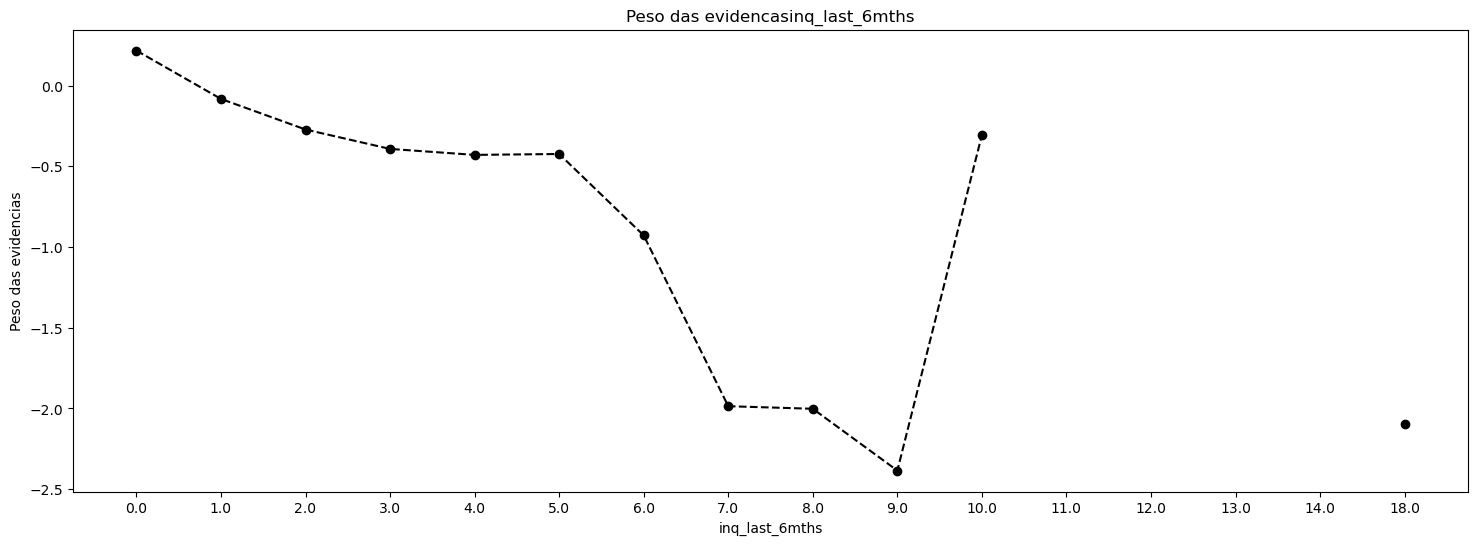

In [175]:
plot_woe(df_temp)
# We plot the weight of evidence values.

In [176]:
# Categories: 0, 1 - 2, 3 - 6, > 6
df_inputs_prepr['inq_last_6mths:0'] = np.where((df_inputs_prepr['inq_last_6mths'] == 0), 1, 0)
df_inputs_prepr['inq_last_6mths:1-2'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 1) & (df_inputs_prepr['inq_last_6mths'] <= 2), 1, 0)
df_inputs_prepr['inq_last_6mths:3-6'] = np.where((df_inputs_prepr['inq_last_6mths'] >= 3) & (df_inputs_prepr['inq_last_6mths'] <= 6), 1, 0)
df_inputs_prepr['inq_last_6mths:>6'] = np.where((df_inputs_prepr['inq_last_6mths'] > 6), 1, 0)

In [177]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'open_acc', df_target_prepr)
df_temp

,open_acc,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,7,1.000000,0.000075,7.0,0.0,0.000084,0.000000,inf,NaN,NaN,inf,inf
1,1.0,32,0.875000,0.000343,28.0,4.0,0.000337,0.000393,-0.152331,0.125000,inf,8.448922e-06,inf
2,2.0,334,0.838323,0.003582,280.0,54.0,0.003371,0.005299,-0.452435,0.036677,0.300105,8.725392e-04,inf
3,3.0,1122,0.852941,0.012031,957.0,165.0,0.011521,0.016192,-0.340383,0.014618,0.112052,1.590106e-03,inf
4,4.0,2560,0.892188,0.027451,2284.0,276.0,0.027496,0.027085,0.015042,0.039246,0.355425,6.174743e-06,inf
5,5.0,4403,0.891438,0.047214,3925.0,478.0,0.047251,0.046909,0.007270,0.000750,0.007772,2.488457e-06,inf
6,6.0,6216,0.890766,0.066655,5537.0,679.0,0.066657,0.066634,0.000346,0.000672,0.006924,7.993547e-09,inf
7,7.0,7433,0.886856,0.079704,6592.0,841.0,0.079358,0.082532,-0.039220,0.003910,0.039567,1.244956e-04,inf
8,8.0,8314,0.893433,0.089151,7428.0,886.0,0.089422,0.086948,0.028054,0.006577,0.067275,6.940085e-05,inf
9,9.0,8768,0.888230,0.094020,7788.0,980.0,0.093756,0.096173,-0.025454,0.005203,0.053508,6.152392e-05,inf


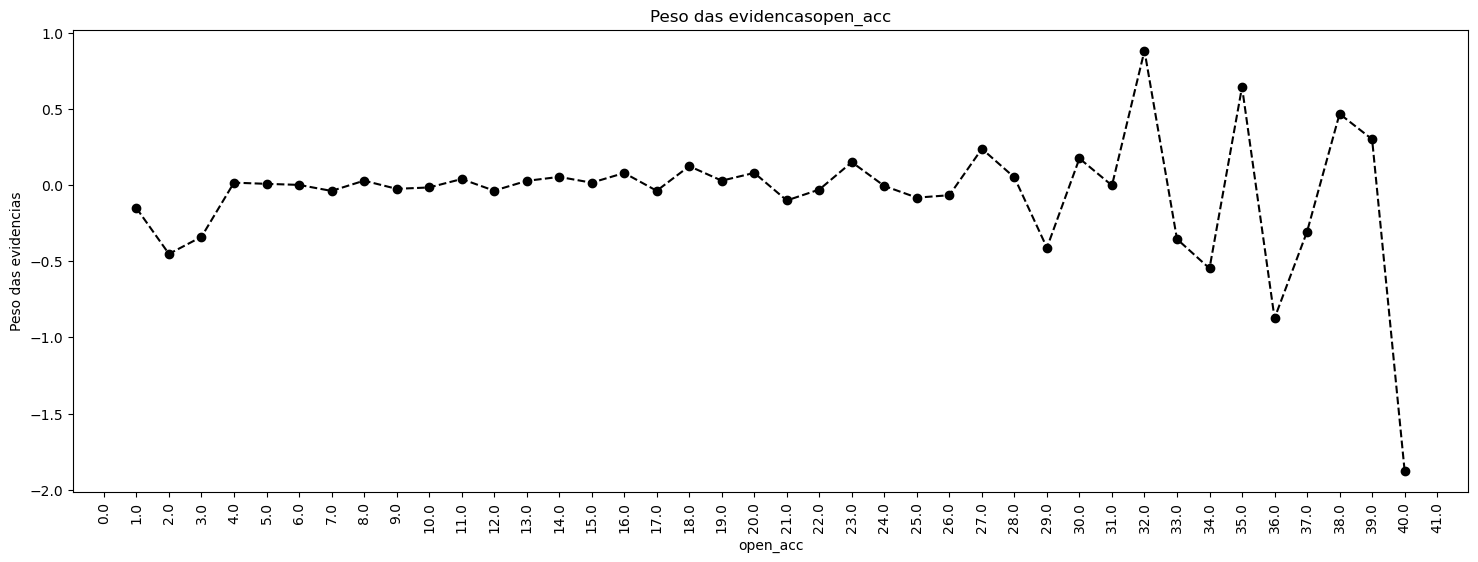

In [178]:
plot_woe(df_temp, 90)


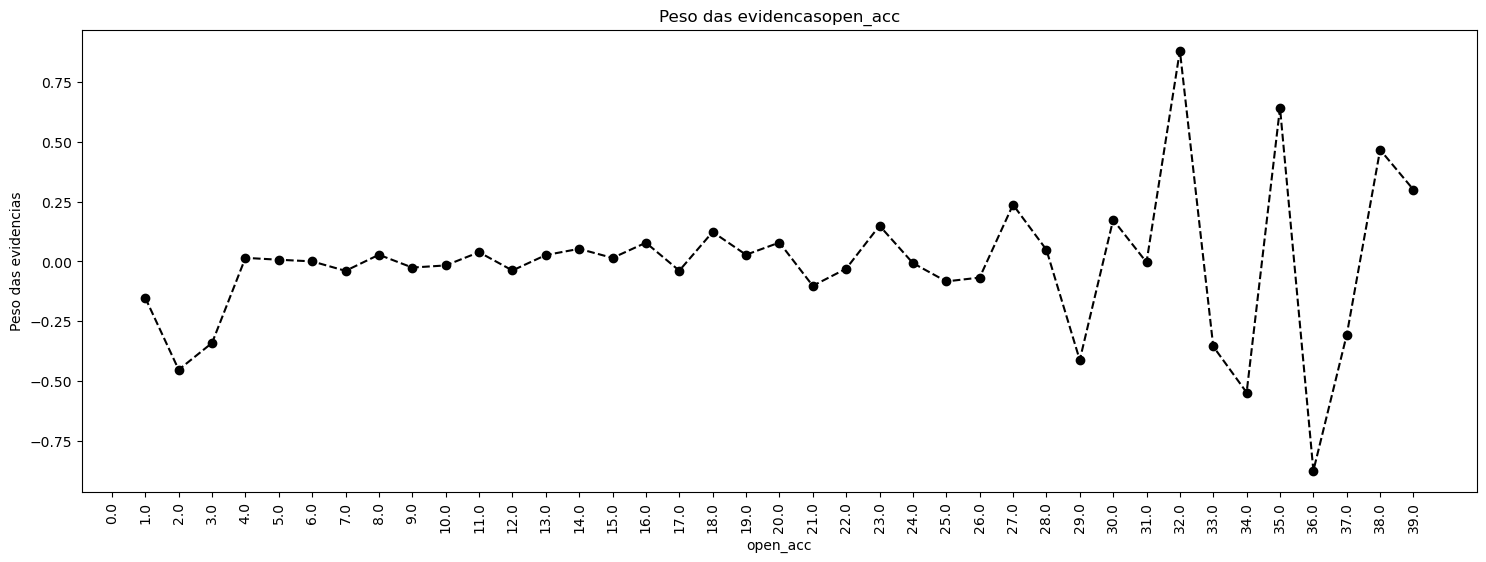

In [179]:
plot_woe(df_temp.iloc[ : 40, :], 90)


In [180]:
df_inputs_prepr['open_acc:0'] = np.where((df_inputs_prepr['open_acc'] == 0), 1, 0)
df_inputs_prepr['open_acc:1-3'] = np.where((df_inputs_prepr['open_acc'] >= 1) & (df_inputs_prepr['open_acc'] <= 3), 1, 0)
df_inputs_prepr['open_acc:4-12'] = np.where((df_inputs_prepr['open_acc'] >= 4) & (df_inputs_prepr['open_acc'] <= 12), 1, 0)
df_inputs_prepr['open_acc:13-17'] = np.where((df_inputs_prepr['open_acc'] >= 13) & (df_inputs_prepr['open_acc'] <= 17), 1, 0)
df_inputs_prepr['open_acc:18-22'] = np.where((df_inputs_prepr['open_acc'] >= 18) & (df_inputs_prepr['open_acc'] <= 22), 1, 0)
df_inputs_prepr['open_acc:23-25'] = np.where((df_inputs_prepr['open_acc'] >= 23) & (df_inputs_prepr['open_acc'] <= 25), 1, 0)
df_inputs_prepr['open_acc:26-30'] = np.where((df_inputs_prepr['open_acc'] >= 26) & (df_inputs_prepr['open_acc'] <= 30), 1, 0)
df_inputs_prepr['open_acc:>=31'] = np.where((df_inputs_prepr['open_acc'] >= 31), 1, 0)

In [181]:
# pub_rec
df_temp = wo_discretize_continuos(df_inputs_prepr, 'pub_rec', df_target_prepr)
# We calculate weight of evidence.
df_temp

,pub_rec,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,80923,0.889179,0.867742,71955.0,8968.0,0.866228,0.880079,-0.015862,NaN,NaN,2.196953e-04,inf
1,1.0,10670,0.901125,0.114415,9615.0,1055.0,0.115750,0.103533,0.111543,0.011946,0.127405,1.362727e-03,inf
2,2.0,1097,0.904284,0.011763,992.0,105.0,0.011942,0.010304,0.147522,0.003160,0.035979,2.416334e-04,inf
3,3.0,331,0.900302,0.003549,298.0,33.0,0.003587,0.003238,0.102345,0.003982,0.045177,3.571813e-05,inf
4,4.0,112,0.857143,0.001201,96.0,16.0,0.001156,0.001570,-0.306481,0.043159,0.408826,1.270283e-04,inf
5,5.0,73,0.904110,0.000783,66.0,7.0,0.000795,0.000687,0.145504,0.046967,0.451985,1.565497e-05,inf
6,6.0,19,0.894737,0.000204,17.0,2.0,0.000205,0.000196,0.041825,0.009373,0.103678,3.506324e-07,inf
7,7.0,14,0.785714,0.000150,11.0,3.0,0.000132,0.000294,-0.798958,0.109023,0.840783,1.294176e-04,inf
8,8.0,5,0.800000,0.000054,4.0,1.0,0.000048,0.000098,-0.711946,0.014286,0.087011,3.558416e-05,inf
9,9.0,2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.200000,inf,inf,inf


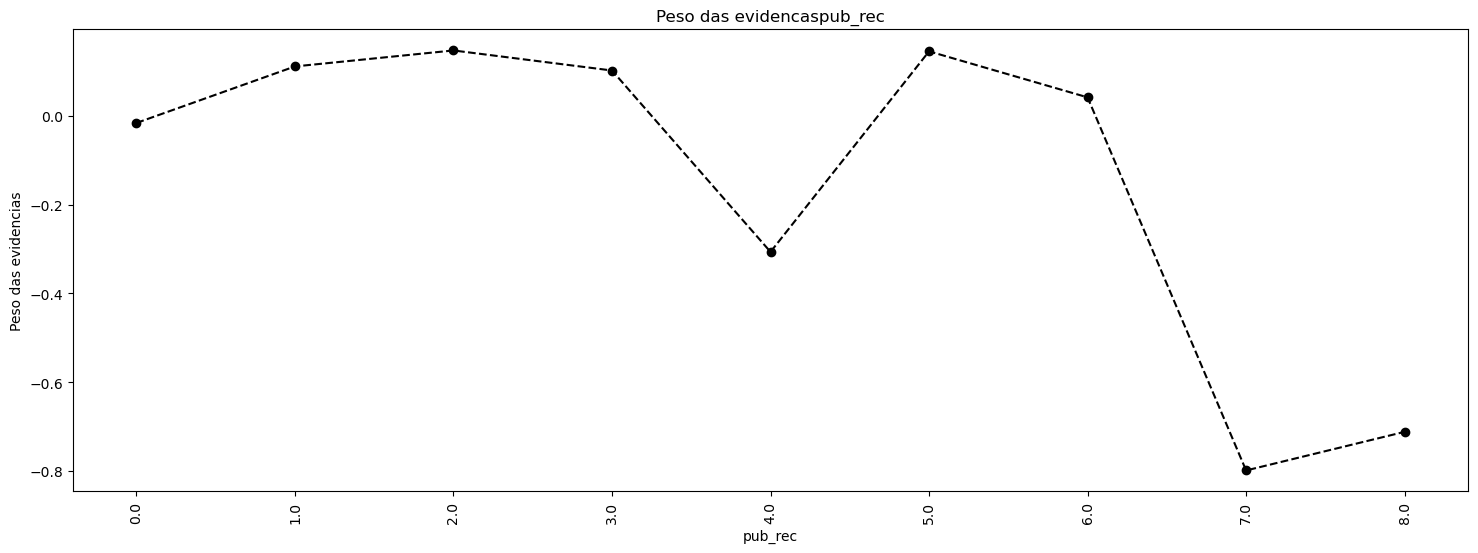

In [182]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [183]:
# Categories '0-2', '3-4', '>=5'
df_inputs_prepr['pub_rec:0-2'] = np.where((df_inputs_prepr['pub_rec'] >= 0) & (df_inputs_prepr['pub_rec'] <= 2), 1, 0)
df_inputs_prepr['pub_rec:3-4'] = np.where((df_inputs_prepr['pub_rec'] >= 3) & (df_inputs_prepr['pub_rec'] <= 4), 1, 0)
df_inputs_prepr['pub_rec:>=5'] = np.where((df_inputs_prepr['pub_rec'] >= 5), 1, 0)

In [184]:
# total_acc
df_inputs_prepr['total_acc_factor'] = pd.cut(df_inputs_prepr['total_acc'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr, 'total_acc_factor', df_target_prepr)
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,total_acc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.156, 3.12]",125,0.776000,0.001340,97.0,28.0,0.001168,0.002748,-0.855734,NaN,NaN,0.001352,inf
1,"(3.12, 6.24]",1499,0.850567,0.016074,1275.0,224.0,0.015349,0.021982,-0.359185,0.074567,0.496549,0.002383,inf
2,"(6.24, 9.36]",3715,0.871871,0.039836,3239.0,476.0,0.038993,0.046712,-0.180639,0.021304,0.178547,0.001395,inf
3,"(9.36, 12.48]",6288,0.874841,0.067427,5501.0,787.0,0.066224,0.077233,-0.153784,0.002970,0.026855,0.001693,inf
4,"(12.48, 15.6]",8289,0.888286,0.088883,7363.0,926.0,0.088639,0.090873,-0.024892,0.013445,0.128892,0.000056,inf
5,"(15.6, 18.72]",9843,0.890176,0.105547,8762.0,1081.0,0.105481,0.106084,-0.005703,0.001890,0.019189,0.000003,inf
6,"(18.72, 21.84]",10270,0.893866,0.110126,9180.0,1090.0,0.110513,0.106968,0.032609,0.003690,0.038312,0.000116,inf
7,"(21.84, 24.96]",9971,0.892789,0.106920,8902.0,1069.0,0.107167,0.104907,0.021312,0.001077,0.011297,0.000048,inf
8,"(24.96, 28.08]",11873,0.892108,0.127315,10592.0,1281.0,0.127512,0.125711,0.014217,0.000681,0.007094,0.000026,inf
9,"(28.08, 31.2]",7289,0.892715,0.078160,6507.0,782.0,0.078334,0.076742,0.020538,0.000607,0.006321,0.000033,inf


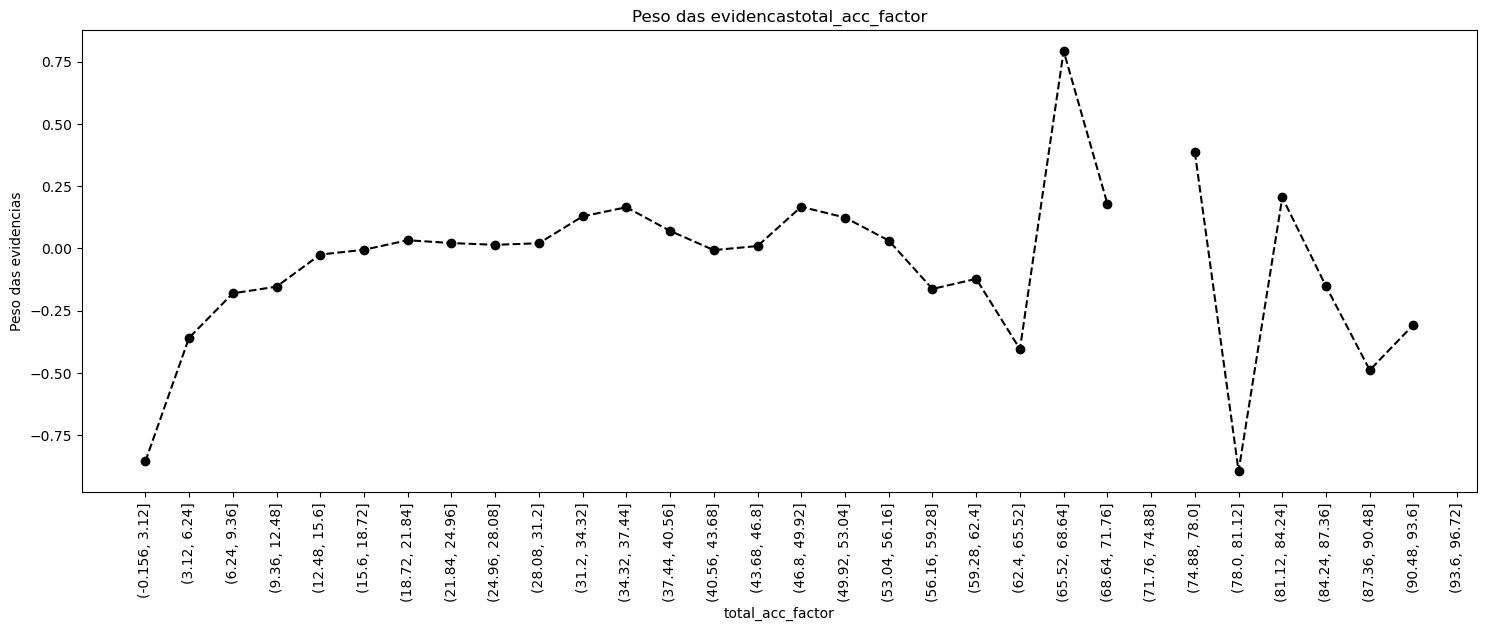

In [185]:
plot_woe(df_temp, 90)


In [186]:
# Categories: '<=27', '28-51', '>51'
df_inputs_prepr['total_acc:<=27'] = np.where((df_inputs_prepr['total_acc'] <= 27), 1, 0)
df_inputs_prepr['total_acc:28-51'] = np.where((df_inputs_prepr['total_acc'] >= 28) & (df_inputs_prepr['total_acc'] <= 51), 1, 0)
df_inputs_prepr['total_acc:>=52'] = np.where((df_inputs_prepr['total_acc'] >= 52), 1, 0)

In [187]:
df_temp = wo_discretize_continuos(df_inputs_prepr, 'acc_now_delinq', df_target_prepr)
df_temp

,acc_now_delinq,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,0.0,92866,0.890821,0.995861,82727.0,10139.0,0.995967,0.994995,0.000976,NaN,NaN,9.486334e-07,0.000298
1,1.0,360,0.872222,0.003861,314.0,46.0,0.003780,0.004514,-0.177429,0.018599,0.178405,1.302188e-04,0.000298
2,2.0,22,0.818182,0.000236,18.0,4.0,0.000217,0.000393,-0.594103,0.054040,0.416674,1.044648e-04,0.000298
3,3.0,4,0.750000,0.000043,3.0,1.0,0.000036,0.000098,-0.999568,0.068182,0.405465,6.199105e-05,0.000298


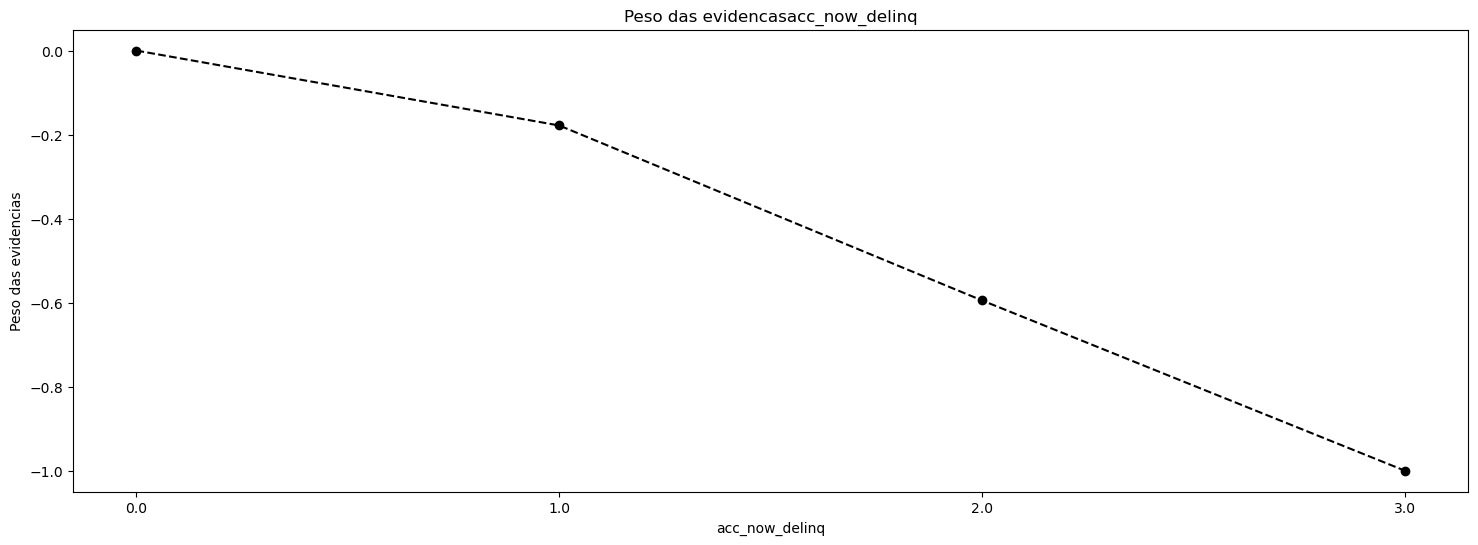

In [188]:
plot_woe(df_temp)


In [189]:
# Categories: '0', '>=1'
df_inputs_prepr['acc_now_delinq:0'] = np.where((df_inputs_prepr['acc_now_delinq'] == 0), 1, 0)
df_inputs_prepr['acc_now_delinq:>=1'] = np.where((df_inputs_prepr['acc_now_delinq'] >= 1), 1, 0)

In [190]:
# total_rev_hi_lim
df_inputs_prepr['total_rev_hi_lim_factor'] = pd.cut(df_inputs_prepr['total_rev_hi_lim'], 2000)
# Here we do fine-classing: using the 'cut' method, we split the variable into 2000 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'total_rev_hi_lim_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()
/home/noise/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,total_rev_hi_lim_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-2013.133, 1006.566]",135,0.874074,0.001703,118.0,17.0,0.001656,0.002118,-0.245886,NaN,NaN,0.000114,inf
1,"(1006.566, 2013.133]",241,0.800830,0.003040,193.0,48.0,0.002709,0.005979,-0.791868,0.073244,0.545982,0.002590,inf
2,"(2013.133, 3019.7]",473,0.849894,0.005966,402.0,71.0,0.005642,0.008844,-0.449585,0.049064,0.342283,0.001440,inf
3,"(3019.7, 4026.266]",729,0.875171,0.009195,638.0,91.0,0.008954,0.011335,-0.235879,0.025277,0.213707,0.000562,inf
4,"(4026.266, 5032.832]",1103,0.883046,0.013912,974.0,129.0,0.013669,0.016069,-0.161759,0.007875,0.074120,0.000388,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"(2008100.168, 2009106.734]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1996,"(2009106.734, 2010113.301]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1997,"(2010113.301, 2011119.867]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
1998,"(2011119.867, 2012126.434]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


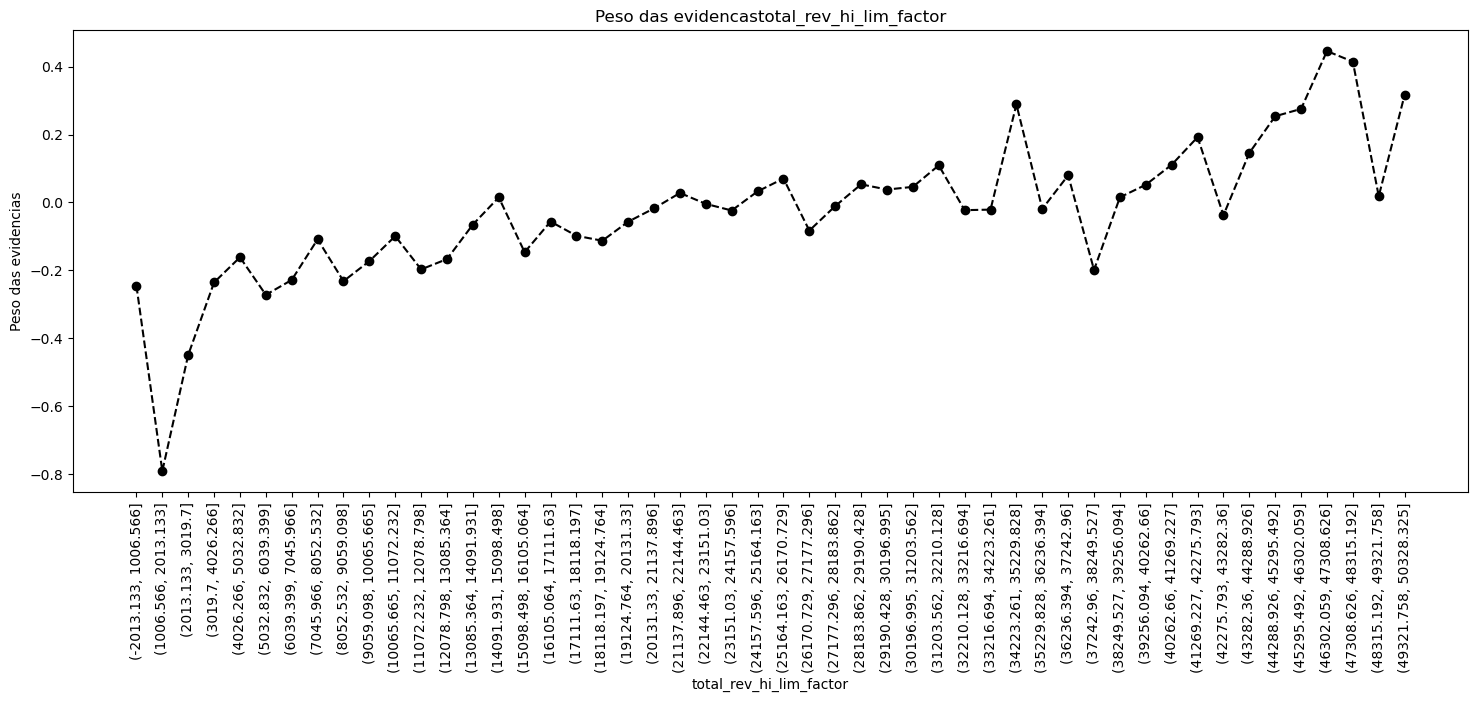

In [191]:
plot_woe(df_temp.iloc[: 50, : ], 90)
# We plot the weight of evidence values.

In [192]:
# Categories
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
df_inputs_prepr['total_rev_hi_lim:<=5K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] <= 5000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:5K-10K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 5000) & (df_inputs_prepr['total_rev_hi_lim'] <= 10000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:10K-20K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 10000) & (df_inputs_prepr['total_rev_hi_lim'] <= 20000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:20K-30K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 20000) & (df_inputs_prepr['total_rev_hi_lim'] <= 30000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:30K-40K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 30000) & (df_inputs_prepr['total_rev_hi_lim'] <= 40000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:40K-55K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 40000) & (df_inputs_prepr['total_rev_hi_lim'] <= 55000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:55K-95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 55000) & (df_inputs_prepr['total_rev_hi_lim'] <= 95000), 1, 0)
df_inputs_prepr['total_rev_hi_lim:>95K'] = np.where((df_inputs_prepr['total_rev_hi_lim'] > 95000), 1, 0)

In [193]:
# installment
df_inputs_prepr['installment_factor'] = pd.cut(df_inputs_prepr['installment'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'installment_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,installment_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(14.369, 43.585]",485,0.872165,0.005201,423.0,62.0,0.005092,0.006084,-0.178003,NaN,NaN,0.000177,inf
1,"(43.585, 71.41]",1246,0.904494,0.013361,1127.0,119.0,0.013567,0.011678,0.149950,0.032329,0.327953,0.000283,inf
2,"(71.41, 99.235]",1731,0.895436,0.018562,1550.0,181.0,0.018660,0.017763,0.049273,0.009058,0.100678,0.000044,inf
3,"(99.235, 127.06]",2292,0.896597,0.024577,2055.0,237.0,0.024739,0.023258,0.061730,0.001161,0.012458,0.000091,inf
4,"(127.06, 154.885]",2602,0.886241,0.027901,2306.0,296.0,0.027761,0.029048,-0.045330,0.010356,0.107061,0.000058,inf
5,"(154.885, 182.71]",4133,0.897653,0.044318,3710.0,423.0,0.044663,0.041511,0.073174,0.011412,0.118505,0.000231,inf
6,"(182.71, 210.535]",4109,0.905086,0.044061,3719.0,390.0,0.044771,0.038273,0.156823,0.007433,0.083648,0.001019,inf
7,"(210.535, 238.36]",3730,0.901877,0.039997,3364.0,366.0,0.040497,0.035918,0.120012,0.003210,0.036811,0.000550,inf
8,"(238.36, 266.185]",4660,0.899785,0.049969,4193.0,467.0,0.050477,0.045829,0.096602,0.002091,0.023410,0.000449,inf
9,"(266.185, 294.01]",4975,0.888844,0.053347,4422.0,553.0,0.053234,0.054269,-0.019251,0.010941,0.115853,0.000020,inf


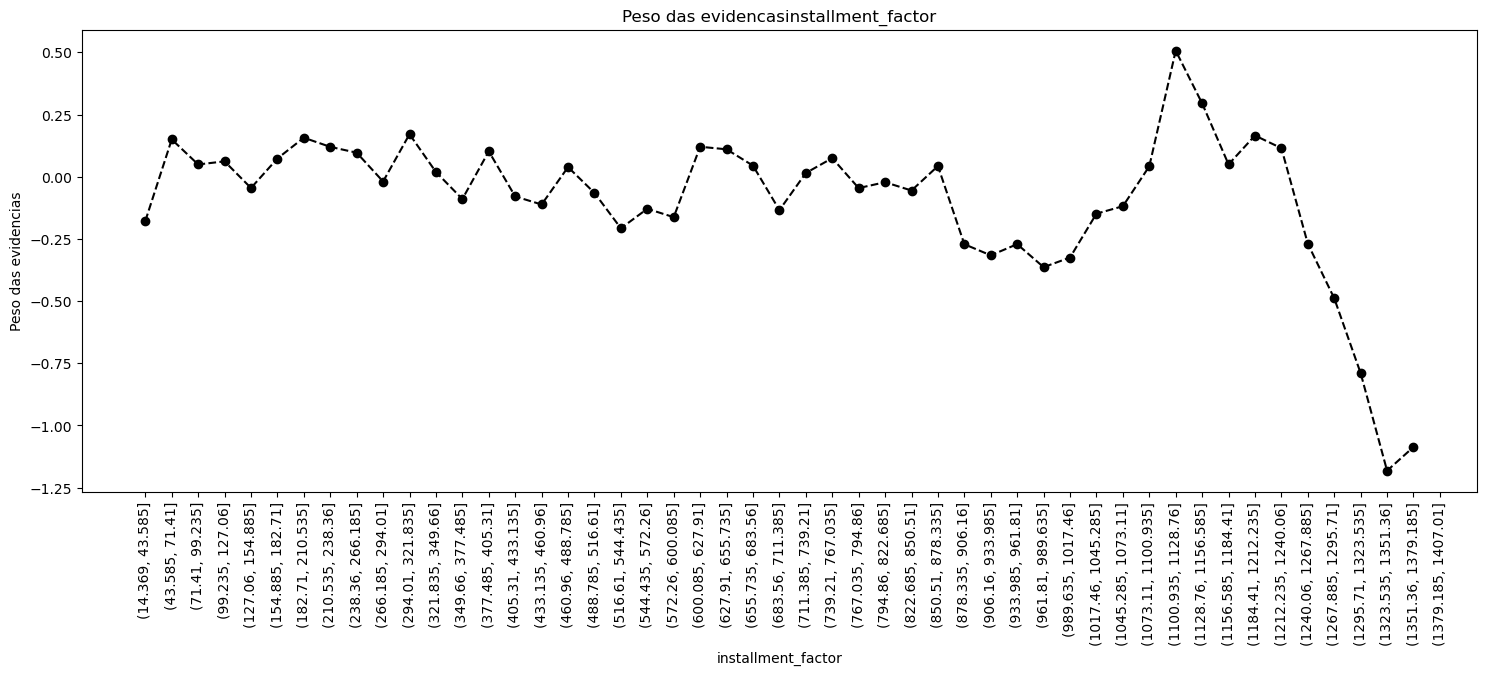

In [194]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [195]:
# annual_inc
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'annual_inc_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-2695.2, 154704.0]",89203,0.889040,0.956529,79305.0,9898.0,0.954711,0.971344,-0.017272,NaN,NaN,0.000287,inf
1,"(154704.0, 304608.0]",3626,0.926641,0.038882,3360.0,266.0,0.040449,0.026104,0.437959,0.037601,0.455231,0.006283,inf
2,"(304608.0, 454512.0]",282,0.929078,0.003024,262.0,20.0,0.003154,0.001963,0.474372,0.002437,0.036412,0.000565,inf
3,"(454512.0, 604416.0]",86,0.965116,0.000922,83.0,3.0,0.000999,0.000294,1.221988,0.036038,0.747616,0.000861,inf
4,"(604416.0, 754320.0]",23,0.956522,0.000247,22.0,1.0,0.000265,0.000098,0.992802,0.008595,0.229186,0.000166,inf
5,"(754320.0, 904224.0]",18,0.944444,0.000193,17.0,1.0,0.000205,0.000098,0.734973,0.012077,0.257829,0.000078,inf
6,"(904224.0, 1054128.0]",7,1.000000,0.000075,7.0,0.0,0.000084,0.000000,inf,0.055556,inf,inf,inf
7,"(1054128.0, 1204032.0]",6,1.000000,0.000064,6.0,0.0,0.000072,0.000000,inf,0.000000,NaN,inf,inf
8,"(1204032.0, 1353936.0]",2,0.500000,0.000021,1.0,1.0,0.000012,0.000098,-2.098241,0.500000,inf,0.000181,inf
9,"(1353936.0, 1503840.0]",2,1.000000,0.000021,2.0,0.0,0.000024,0.000000,inf,0.500000,inf,inf,inf


In [196]:
df_inputs_prepr['annual_inc_factor'] = pd.cut(df_inputs_prepr['annual_inc'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'annual_inc_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-2695.2, 79752.0]",62621,0.877932,0.671488,54977.0,7644.0,0.661839,0.750147,-0.125247,NaN,NaN,0.011060,inf
1,"(79752.0, 154704.0]",26582,0.915206,0.285040,24328.0,2254.0,0.292872,0.221197,0.280681,0.037273,0.405928,0.020118,inf
2,"(154704.0, 229656.0]",2916,0.926269,0.031268,2701.0,215.0,0.032516,0.021099,0.432499,0.011063,0.151818,0.004938,inf
3,"(229656.0, 304608.0]",710,0.928169,0.007613,659.0,51.0,0.007933,0.005005,0.460657,0.001900,0.028159,0.001349,inf
4,"(304608.0, 379560.0]",171,0.929825,0.001834,159.0,12.0,0.001914,0.001178,0.485757,0.001656,0.025100,0.000358,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(7125240.0, 7200192.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
96,"(7200192.0, 7275144.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
97,"(7275144.0, 7350096.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf
98,"(7350096.0, 7425048.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [197]:
# Initial examination shows that there are too few individuals with large income and too many with small income.
# Hence, we are going to have one category for more than 150K, and we are going to apply our approach to determine
# the categories of everyone with 140k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['annual_inc'] <= 140000, : ]
#loan_data_temp = loan_data_temp.reset_index(drop = True)
#df_inputs_prepr_temp

In [198]:
df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'annual_inc_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/tmp/ipykernel_49903/4067983087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp["annual_inc_factor"] = pd.cut(df_inputs_prepr_temp['annual_inc'], 50)
/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

,annual_inc_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(4664.8, 7504.0]",10,1.000000,0.000114,10.0,0.0,0.000128,0.000000,inf,NaN,NaN,inf,inf
1,"(7504.0, 10208.0]",84,0.761905,0.000958,64.0,20.0,0.000822,0.002043,-0.911157,0.238095,inf,0.001113,inf
2,"(10208.0, 12912.0]",123,0.780488,0.001403,96.0,27.0,0.001232,0.002758,-0.805796,0.018583,0.105361,0.001230,inf
3,"(12912.0, 15616.0]",304,0.851974,0.003467,259.0,45.0,0.003325,0.004597,-0.324142,0.071486,0.481654,0.000413,inf
4,"(15616.0, 18320.0]",383,0.827676,0.004368,317.0,66.0,0.004069,0.006743,-0.505060,0.024297,0.180919,0.001350,inf
5,"(18320.0, 21024.0]",733,0.840382,0.008359,616.0,117.0,0.007907,0.011953,-0.413234,0.012706,0.091826,0.001672,inf
6,"(21024.0, 23728.0]",704,0.846591,0.008028,596.0,108.0,0.007651,0.011034,-0.366198,0.006209,0.047036,0.001239,inf
7,"(23728.0, 26432.0]",1785,0.861064,0.020356,1537.0,248.0,0.019730,0.025337,-0.250148,0.014474,0.116050,0.001403,inf
8,"(26432.0, 29136.0]",1355,0.853137,0.015452,1156.0,199.0,0.014839,0.020331,-0.314891,0.007928,0.064743,0.001729,inf
9,"(29136.0, 31840.0]",2292,0.854276,0.026137,1958.0,334.0,0.025134,0.034123,-0.305769,0.001139,0.009122,0.002749,inf


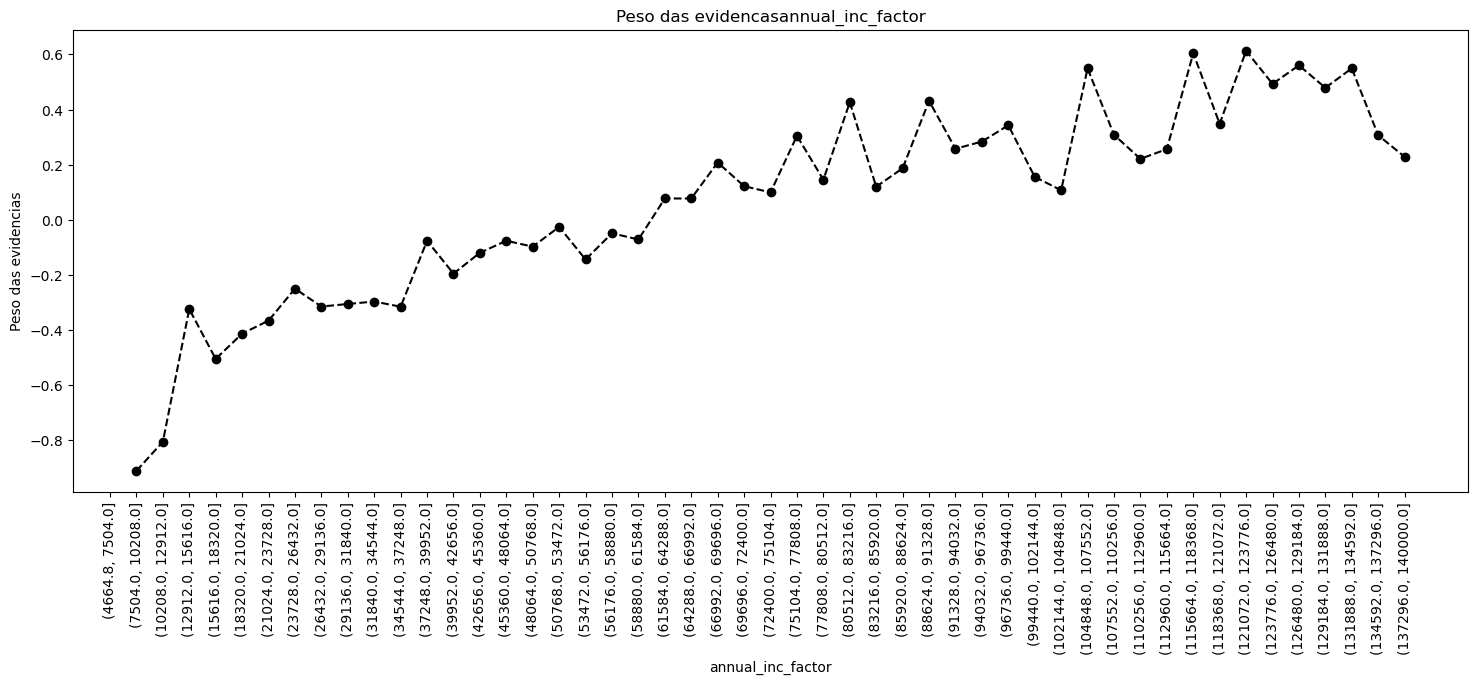

In [199]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [200]:
df_inputs_prepr['annual_inc:<20K'] = np.where((df_inputs_prepr['annual_inc'] <= 20000), 1, 0)
df_inputs_prepr['annual_inc:20K-30K'] = np.where((df_inputs_prepr['annual_inc'] > 20000) & (df_inputs_prepr['annual_inc'] <= 30000), 1, 0)
df_inputs_prepr['annual_inc:30K-40K'] = np.where((df_inputs_prepr['annual_inc'] > 30000) & (df_inputs_prepr['annual_inc'] <= 40000), 1, 0)
df_inputs_prepr['annual_inc:40K-50K'] = np.where((df_inputs_prepr['annual_inc'] > 40000) & (df_inputs_prepr['annual_inc'] <= 50000), 1, 0)
df_inputs_prepr['annual_inc:50K-60K'] = np.where((df_inputs_prepr['annual_inc'] > 50000) & (df_inputs_prepr['annual_inc'] <= 60000), 1, 0)
df_inputs_prepr['annual_inc:60K-70K'] = np.where((df_inputs_prepr['annual_inc'] > 60000) & (df_inputs_prepr['annual_inc'] <= 70000), 1, 0)
df_inputs_prepr['annual_inc:70K-80K'] = np.where((df_inputs_prepr['annual_inc'] > 70000) & (df_inputs_prepr['annual_inc'] <= 80000), 1, 0)
df_inputs_prepr['annual_inc:80K-90K'] = np.where((df_inputs_prepr['annual_inc'] > 80000) & (df_inputs_prepr['annual_inc'] <= 90000), 1, 0)
df_inputs_prepr['annual_inc:90K-100K'] = np.where((df_inputs_prepr['annual_inc'] > 90000) & (df_inputs_prepr['annual_inc'] <= 100000), 1, 0)
df_inputs_prepr['annual_inc:100K-120K'] = np.where((df_inputs_prepr['annual_inc'] > 100000) & (df_inputs_prepr['annual_inc'] <= 120000), 1, 0)
df_inputs_prepr['annual_inc:120K-140K'] = np.where((df_inputs_prepr['annual_inc'] > 120000) & (df_inputs_prepr['annual_inc'] <= 140000), 1, 0)
df_inputs_prepr['annual_inc:>140K'] = np.where((df_inputs_prepr['annual_inc'] > 140000), 1, 0)

In [201]:
# mths_since_last_delinq
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_delinq'])]
df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'mths_since_last_delinq_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/tmp/ipykernel_49903/2833956029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_delinq_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_delinq'], 50)
/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas.

,mths_since_last_delinq_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.17, 3.4]",1348,0.868694,0.031283,1171.0,177.0,0.030501,0.037668,-0.211036,NaN,NaN,0.001512,inf
1,"(3.4, 6.8]",1890,0.880423,0.043861,1664.0,226.0,0.043342,0.048095,-0.104055,0.011729,0.106981,0.000495,inf
2,"(6.8, 10.2]",3373,0.887044,0.078276,2992.0,381.0,0.077933,0.081081,-0.039601,0.006621,0.064453,0.000125,inf
3,"(10.2, 13.6]",2496,0.895833,0.057924,2236.0,260.0,0.058241,0.055331,0.051263,0.008789,0.090864,0.000149,inf
4,"(13.6, 17.0]",3165,0.884044,0.073449,2798.0,367.0,0.072880,0.078102,-0.069201,0.011789,0.120464,0.000361,inf
5,"(17.0, 20.4]",2282,0.893076,0.052958,2038.0,244.0,0.053084,0.051926,0.022057,0.009032,0.091258,0.000026,inf
6,"(20.4, 23.8]",2115,0.898345,0.049082,1900.0,215.0,0.049489,0.045754,0.078472,0.005269,0.056415,0.000293,inf
7,"(23.8, 27.2]",2755,0.895463,0.063934,2467.0,288.0,0.064258,0.061290,0.047298,0.002882,0.031174,0.000140,inf
8,"(27.2, 30.6]",1929,0.896319,0.044766,1729.0,200.0,0.045035,0.042562,0.056482,0.000857,0.009183,0.000140,inf
9,"(30.6, 34.0]",2453,0.891969,0.056926,2188.0,265.0,0.056991,0.056395,0.010514,0.004350,0.045968,0.000006,inf


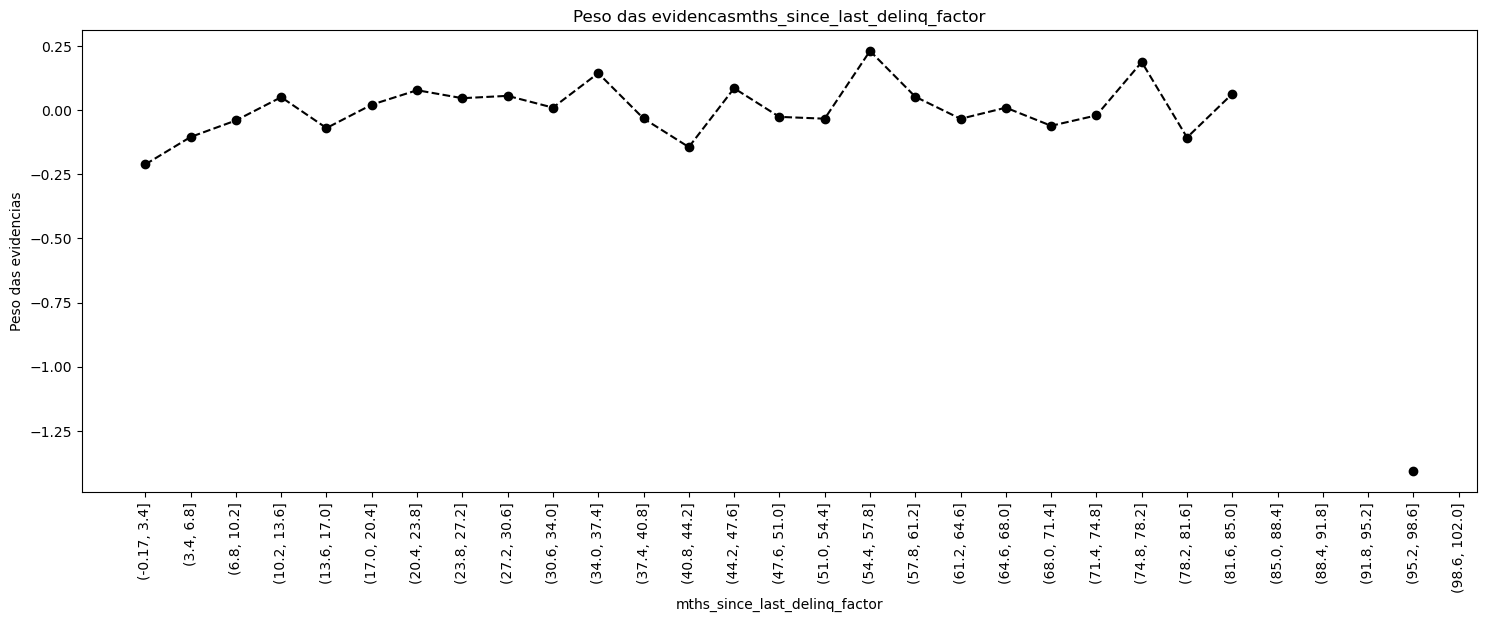

In [202]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [203]:
# Categories: Missing, 0-3, 4-30, 31-56, >=57
df_inputs_prepr['mths_since_last_delinq:Missing'] = np.where((df_inputs_prepr['mths_since_last_delinq'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_delinq:0-3'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 0) & (df_inputs_prepr['mths_since_last_delinq'] <= 3), 1, 0)
df_inputs_prepr['mths_since_last_delinq:4-30'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 4) & (df_inputs_prepr['mths_since_last_delinq'] <= 30), 1, 0)
df_inputs_prepr['mths_since_last_delinq:31-56'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 31) & (df_inputs_prepr['mths_since_last_delinq'] <= 56), 1, 0)
df_inputs_prepr['mths_since_last_delinq:>=57'] = np.where((df_inputs_prepr['mths_since_last_delinq'] >= 57), 1, 0)

In [204]:
# dti
df_inputs_prepr['dti_factor'] = pd.cut(df_inputs_prepr['dti'], 100)
# Here we do fine-classing: using the 'cut' method, we split the variable into 100 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr, 'dti_factor', df_target_prepr)
# We calculate weight of evidence.
df_temp

/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby(df.columns[0], as_index=False)[df.columns[1]].mean()


,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.04, 0.4]",187,0.893048,0.002005,167.0,20.0,0.002010,0.001963,0.024021,NaN,NaN,1.146199e-06,0.038146
1,"(0.4, 0.8]",184,0.880435,0.001973,162.0,22.0,0.001950,0.002159,-0.101687,0.012613,0.125708,2.122675e-05,0.038146
2,"(0.8, 1.2]",223,0.892377,0.002391,199.0,24.0,0.002396,0.002355,0.017010,0.011942,0.118697,6.873241e-07,0.038146
3,"(1.2, 1.6]",255,0.905882,0.002734,231.0,24.0,0.002781,0.002355,0.166123,0.013506,0.149113,7.070827e-05,0.038146
4,"(1.6, 2.0]",315,0.892063,0.003378,281.0,34.0,0.003383,0.003337,0.013753,0.013819,0.152370,6.355064e-07,0.038146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",54,0.888889,0.000579,48.0,6.0,0.000578,0.000589,-0.018799,0.044444,0.387766,2.061467e-07,0.038146
96,"(38.39, 38.79]",37,0.837838,0.000397,31.0,6.0,0.000373,0.000589,-0.456013,0.051051,0.437214,9.832543e-05,0.038146
97,"(38.79, 39.19]",45,0.844444,0.000483,38.0,7.0,0.000457,0.000687,-0.406565,0.006607,0.049448,9.330087e-05,0.038146
98,"(39.19, 39.59]",44,0.931818,0.000472,41.0,3.0,0.000494,0.000294,0.516719,0.087374,0.923284,1.029156e-04,0.038146


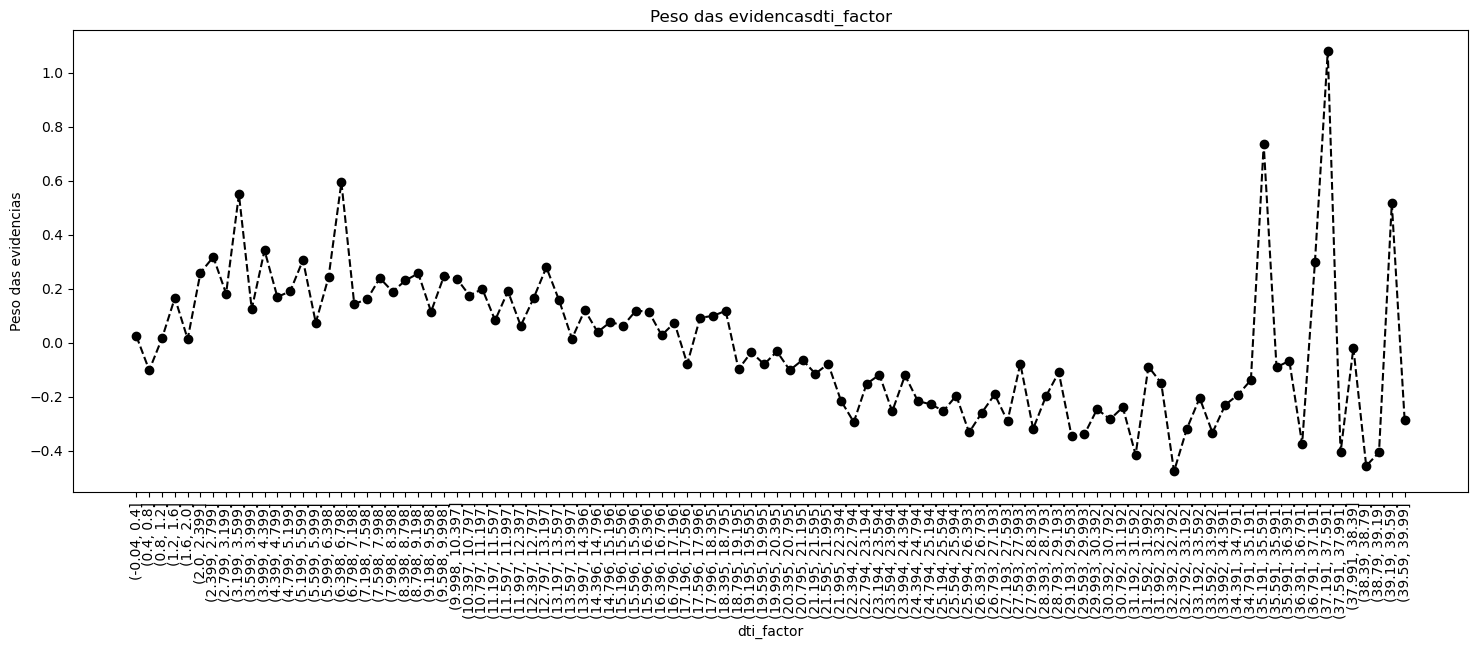

In [205]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [206]:
# Similarly to income, initial examination shows that most values are lower than 200.
# Hence, we are going to have one category for more than 35, and we are going to apply our approach to determine
# the categories of everyone with 150k or less.
df_inputs_prepr_temp = df_inputs_prepr.loc[df_inputs_prepr['dti'] <= 35, : ]

In [207]:
df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'dti_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/tmp/ipykernel_49903/873747522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['dti_factor'] = pd.cut(df_inputs_prepr_temp['dti'], 50)
/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_count = df.groupby(df.columns[0], as_index=False)[df.columns[1]].count()
/home/noise/Documentos/credit_risk/src/utils_modelling.py:186: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current 

,dti_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.035, 0.7]",328,0.884146,0.003544,290.0,38.0,0.003518,0.003758,-0.066005,NaN,NaN,0.000016,0.033919
1,"(0.7, 1.4]",393,0.903308,0.004246,355.0,38.0,0.004306,0.003758,0.136232,0.019162,0.202237,0.000075,0.033919
2,"(1.4, 2.1]",536,0.895522,0.005792,480.0,56.0,0.005823,0.005538,0.050135,0.007785,0.086097,0.000014,0.033919
3,"(2.1, 2.8]",607,0.915980,0.006559,556.0,51.0,0.006745,0.005044,0.290643,0.020458,0.240508,0.000494,0.033919
4,"(2.8, 3.5]",811,0.924784,0.008763,750.0,61.0,0.009098,0.006032,0.410900,0.008804,0.120257,0.001260,0.033919
5,"(3.5, 4.2]",970,0.903093,0.010481,876.0,94.0,0.010626,0.009296,0.133772,0.021691,0.277128,0.000178,0.033919
6,"(4.2, 4.9]",1140,0.913158,0.012318,1041.0,99.0,0.012628,0.009790,0.254518,0.010065,0.120746,0.000722,0.033919
7,"(4.9, 5.6]",1370,0.911679,0.014803,1249.0,121.0,0.015151,0.011966,0.236009,0.001479,0.018509,0.000752,0.033919
8,"(5.6, 6.3]",1491,0.904762,0.016111,1349.0,142.0,0.016364,0.014043,0.152992,0.006917,0.083016,0.000355,0.033919
9,"(6.3, 7.0]",1722,0.926829,0.018607,1596.0,126.0,0.019360,0.012460,0.440674,0.022067,0.287682,0.003041,0.033919


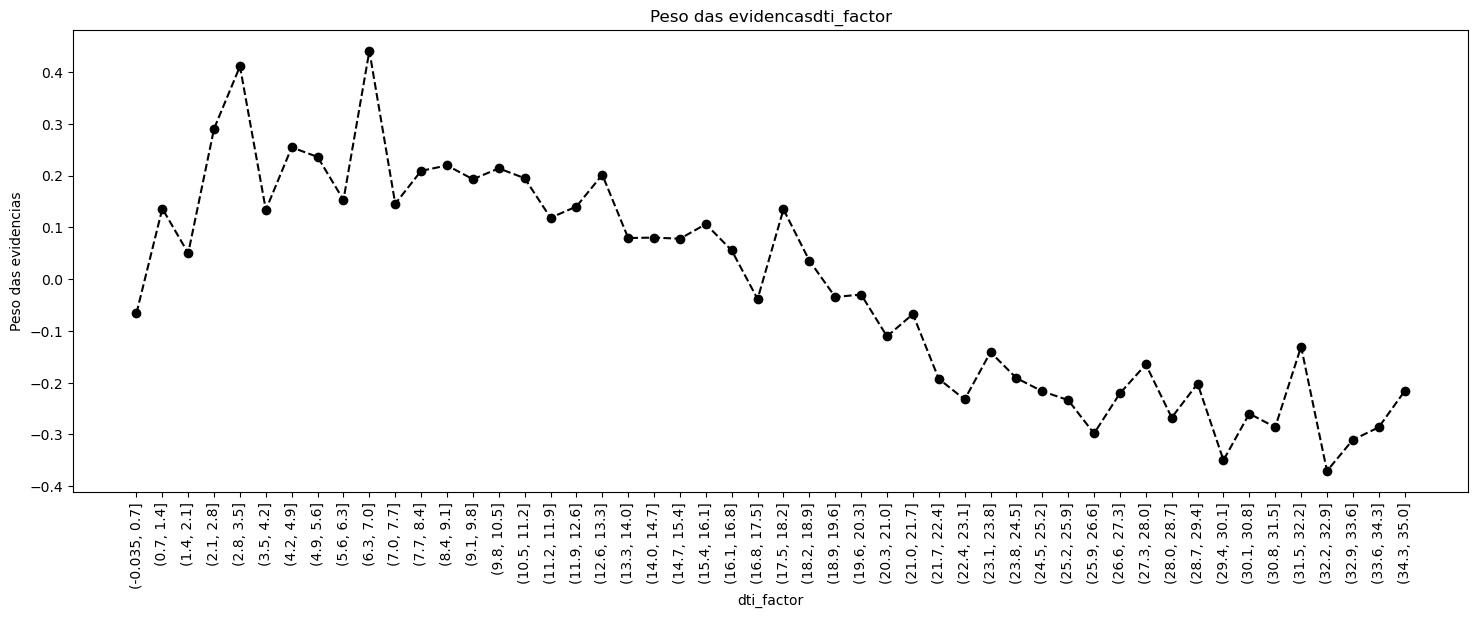

In [208]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [209]:
# Categories:
df_inputs_prepr['dti:<=1.4'] = np.where((df_inputs_prepr['dti'] <= 1.4), 1, 0)
df_inputs_prepr['dti:1.4-3.5'] = np.where((df_inputs_prepr['dti'] > 1.4) & (df_inputs_prepr['dti'] <= 3.5), 1, 0)
df_inputs_prepr['dti:3.5-7.7'] = np.where((df_inputs_prepr['dti'] > 3.5) & (df_inputs_prepr['dti'] <= 7.7), 1, 0)
df_inputs_prepr['dti:7.7-10.5'] = np.where((df_inputs_prepr['dti'] > 7.7) & (df_inputs_prepr['dti'] <= 10.5), 1, 0)
df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
df_inputs_prepr['dti:20.3-21.7'] = np.where((df_inputs_prepr['dti'] > 20.3) & (df_inputs_prepr['dti'] <= 21.7), 1, 0)
df_inputs_prepr['dti:21.7-22.4'] = np.where((df_inputs_prepr['dti'] > 21.7) & (df_inputs_prepr['dti'] <= 22.4), 1, 0)
df_inputs_prepr['dti:22.4-35'] = np.where((df_inputs_prepr['dti'] > 22.4) & (df_inputs_prepr['dti'] <= 35), 1, 0)
df_inputs_prepr['dti:>35'] = np.where((df_inputs_prepr['dti'] > 35), 1, 0)

/tmp/ipykernel_49903/284476014.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:10.5-16.1'] = np.where((df_inputs_prepr['dti'] > 10.5) & (df_inputs_prepr['dti'] <= 16.1), 1, 0)
/tmp/ipykernel_49903/284476014.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['dti:16.1-20.3'] = np.where((df_inputs_prepr['dti'] > 16.1) & (df_inputs_prepr['dti'] <= 20.3), 1, 0)
/tmp/ipykernel_49903/284476014.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fra

In [210]:
# mths_since_last_record
# We have to create one category for missing values and do fine and coarse classing for the rest.
df_inputs_prepr_temp = df_inputs_prepr[pd.notnull(df_inputs_prepr['mths_since_last_record'])]
#sum(loan_data_temp['mths_since_last_record'].isnull())
df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
# Here we do fine-classing: using the 'cut' method, we split the variable into 50 categories by its values.
df_temp = wo_discretize_continuos(df_inputs_prepr_temp, 'mths_since_last_record_factor', df_target_prepr[df_inputs_prepr_temp.index])
# We calculate weight of evidence.
df_temp

/tmp/ipykernel_49903/4294264355.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
/tmp/ipykernel_49903/4294264355.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inputs_prepr_temp['mths_since_last_record_factor'] = pd.cut(df_inputs_prepr_temp['mths_since_last_record'], 50)
/home/noise/Documentos/credit_risk/src/utils_modelling.py:185: FutureWarning: The default of observed=False is deprecated and

,mths_since_last_record_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,"(-0.129, 2.58]",244,0.741803,0.019410,181.0,63.0,0.016036,0.049065,-1.118309,NaN,NaN,3.693694e-02,inf
1,"(2.58, 5.16]",36,0.888889,0.002864,32.0,4.0,0.002835,0.003115,-0.094230,0.147086,1.024079,2.639800e-05,inf
2,"(5.16, 7.74]",39,0.923077,0.003102,36.0,3.0,0.003190,0.002336,0.311235,0.034188,0.405465,2.655028e-04,inf
3,"(7.74, 10.32]",66,0.939394,0.005250,62.0,4.0,0.005493,0.003115,0.567169,0.016317,0.255933,1.348602e-03,inf
4,"(10.32, 12.9]",42,0.833333,0.003341,35.0,7.0,0.003101,0.005452,-0.564234,0.106061,1.131402,1.326401e-03,inf
5,"(12.9, 15.48]",69,0.869565,0.005489,60.0,9.0,0.005316,0.007009,-0.276551,0.036232,0.287682,4.683387e-04,inf
6,"(15.48, 18.06]",95,0.863158,0.007557,82.0,13.0,0.007265,0.010125,-0.331902,0.006407,0.055350,9.491107e-04,inf
7,"(18.06, 20.64]",58,0.965517,0.004614,56.0,2.0,0.004961,0.001558,1.158533,0.102359,1.490435,3.943447e-03,inf
8,"(20.64, 23.22]",101,0.891089,0.008034,90.0,11.0,0.007974,0.008567,-0.071757,0.074428,1.230290,4.256648e-05,inf
9,"(23.22, 25.8]",94,0.946809,0.007478,89.0,5.0,0.007885,0.003894,0.705527,0.055719,0.777284,2.815827e-03,inf


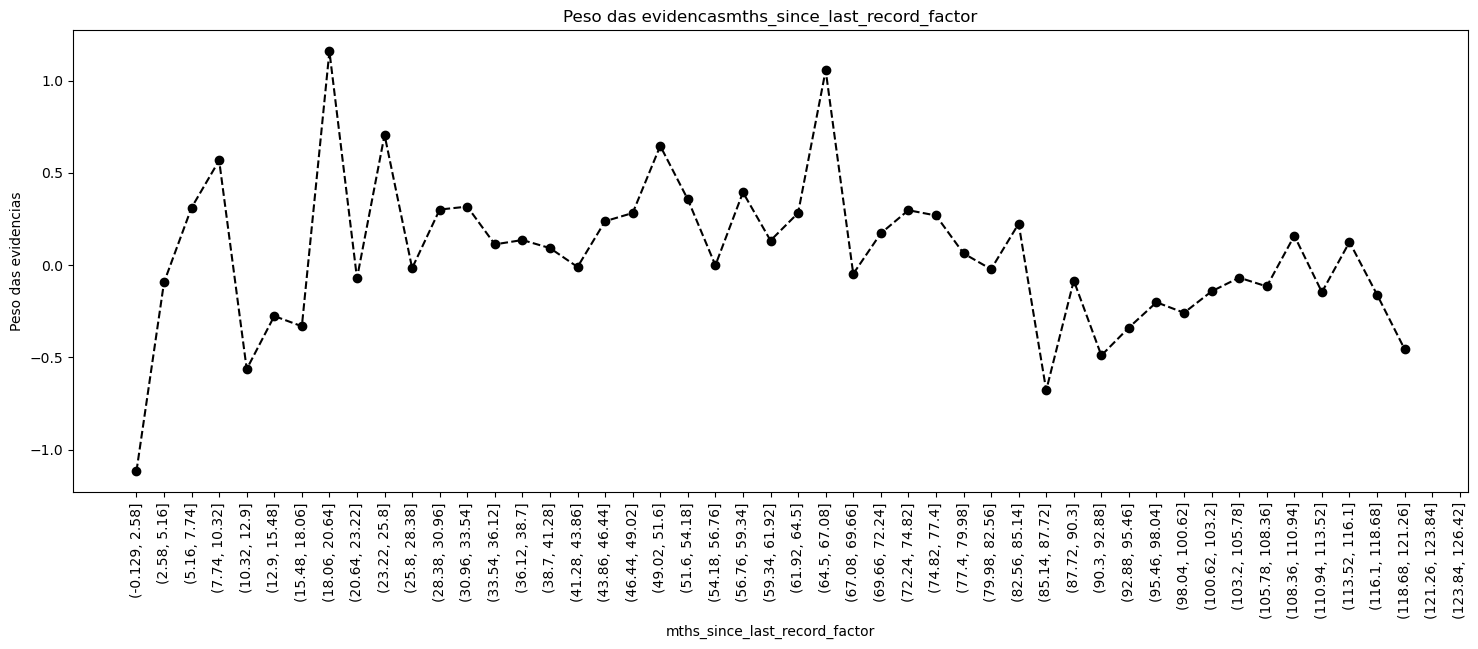

In [211]:
plot_woe(df_temp, 90)
# We plot the weight of evidence values.

In [212]:
# Categories: 'Missing', '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
df_inputs_prepr['mths_since_last_record:3-20'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 3) & (df_inputs_prepr['mths_since_last_record'] <= 20), 1, 0)
df_inputs_prepr['mths_since_last_record:21-31'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 21) & (df_inputs_prepr['mths_since_last_record'] <= 31), 1, 0)
df_inputs_prepr['mths_since_last_record:32-80'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 32) & (df_inputs_prepr['mths_since_last_record'] <= 80), 1, 0)
df_inputs_prepr['mths_since_last_record:81-86'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 81) & (df_inputs_prepr['mths_since_last_record'] <= 86), 1, 0)
df_inputs_prepr['mths_since_last_record:>86'] = np.where((df_inputs_prepr['mths_since_last_record'] > 86), 1, 0)

/tmp/ipykernel_49903/1059239224.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:Missing'] = np.where((df_inputs_prepr['mths_since_last_record'].isnull()), 1, 0)
/tmp/ipykernel_49903/1059239224.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_inputs_prepr['mths_since_last_record:0-2'] = np.where((df_inputs_prepr['mths_since_last_record'] >= 0) & (df_inputs_prepr['mths_since_last_record'] <= 2), 1, 0)
/tmp/ipykernel_49903/1059239224.py:4: PerformanceWarning: DataFrame is highly fra

In [213]:
#####
#loan_data_inputs_train = df_inputs_prepr
#####
loan_data_inputs_test = df_inputs_prepr

In [214]:
#loan_data_inputs_train.to_csv('loan_data_inputs_train.csv')
#df_target_prepr.to_csv('loan_data_targets_train.csv')
loan_data_inputs_test.to_csv('loan_data_inputs_test.csv')
df_target_test.to_csv('loan_data_targets_test.csv')